# ⚡ Machine Learning Project: Electricity Price Explanation ⚙️📉

**LANOTTE-MORO Alix, CHANDECLERC Antoine, GILLES Julien, FLEURY Nathan**  
**November 14, 2024**

## Project Overview

This project focuses on analyzing daily variations in electricity futures prices within the European market, specifically for France and Germany. Given the complex interplay of meteorological, energy production, and geopolitical factors impacting price fluctuations, the objective is to build a model that explains these movements rather than predicting exact prices. Leveraging Spearman correlation as the primary evaluation metric, we will employ a range of models—from linear regression benchmarks to advanced machine learning approaches (e.g., Random Forests, XGBoost, and RNNs)—to capture both linear and non-linear influences on price variations. This model aims to support energy producers, traders, and policymakers by providing insights to optimize trading strategies, manage risks, and strengthen the resilience of the European energy grid.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler

from scipy.stats import spearmanr

import warnings 
warnings.filterwarnings("ignore")

## Data Importation and first preview

In [2]:
X_df =pd.read_csv('X_train_NHkHMNU.csv', delimiter= ',')
y_df =pd.read_csv('y_train_ZAN5mwg.csv', delimiter= ',')
X_test_df =pd.read_csv('X_test_final.csv', delimiter= ',')

df = pd.merge(X_df,y_df,on='ID')

print(df.shape)
df.head(10)

(1494, 36)


,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445,0.028313
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365,-0.112516
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952,-0.180840
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948,-0.260356
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378,-0.071733
5,1520,467,FR,-0.295296,-0.765120,-0.717490,0.717490,-1.117139,-0.200305,1.117139,...,-0.962519,-0.193837,-0.871600,-0.917234,0.102046,0.472708,0.891049,0.861408,1.124457,0.932105
6,1546,144,FR,-0.234965,-0.677085,0.399588,-0.399588,0.183998,-0.986235,-0.183998,...,-1.658394,-0.529800,-0.318920,-1.220760,-0.512991,0.147507,1.889739,0.498226,0.681739,0.192680
7,1069,1136,FR,0.332223,-0.546797,-0.507773,0.507773,NaN,0.569585,NaN,...,-0.744328,-0.051535,-0.701035,-0.394857,1.990978,0.902719,0.206769,0.993304,-0.223739,0.112850
8,1323,83,FR,-0.023023,-0.604694,-1.196787,1.196787,-0.519339,0.373109,0.519339,...,-0.207390,0.009356,-0.261496,-0.841560,-1.024980,-1.564174,2.688208,3.061210,3.755240,0.076153
9,1618,307,FR,0.564657,0.273776,-0.439063,0.439063,-0.636654,0.342057,0.636654,...,-0.972344,-0.806435,-0.752273,-0.767578,-0.371475,-0.459768,-1.487154,-0.692378,-0.768283,0.000000


### Pourcentage of missing values by columns

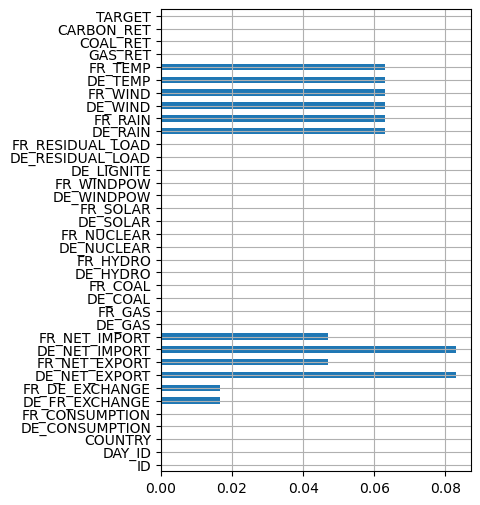

In [3]:
nb_missing = df.isna().sum()
rate_missing = nb_missing / df.ID.nunique()
fig, ax = plt.subplots(figsize=(4,6))
ax1 = ax
rate_missing.plot(kind="barh", ax=ax1)
ax1.grid()

We notice that there are a certain number of missing values, particularly for DE_NET_IMPORT and DE_NET_EXPORT, where the rate exceeds 8%. These data will need to be handled. Several options are available to us: filling them with the mean, replacing them with zeros, etc.

We chose to fill the missing values in each column with the respective column mean. Since the dataset is relatively small (around 1500 rows), dropping rows with missing values would significantly reduce the available data. By imputing missing values with the mean, we retain as many rows as possible, ensuring that the dataset remains comprehensive.

In [4]:
#List of Columns with missing values
columns_to_fill = [
    "DE_FR_EXCHANGE", "FR_DE_EXCHANGE", "DE_NET_EXPORT", "FR_NET_EXPORT", 
    "DE_NET_IMPORT", "FR_NET_IMPORT", "DE_RAIN", "FR_RAIN", 
    "DE_WIND", "FR_WIND", "DE_TEMP", "FR_TEMP"
]
df_general = df

#Fill missing values with the mean
for column in columns_to_fill:
    if column in df_general.columns:
        df_general[column].fillna(df_general[column].mean(), inplace=True)

### Plot of the distribution of each columns of the data

Text(0.5, 1.0, 'TARGET')

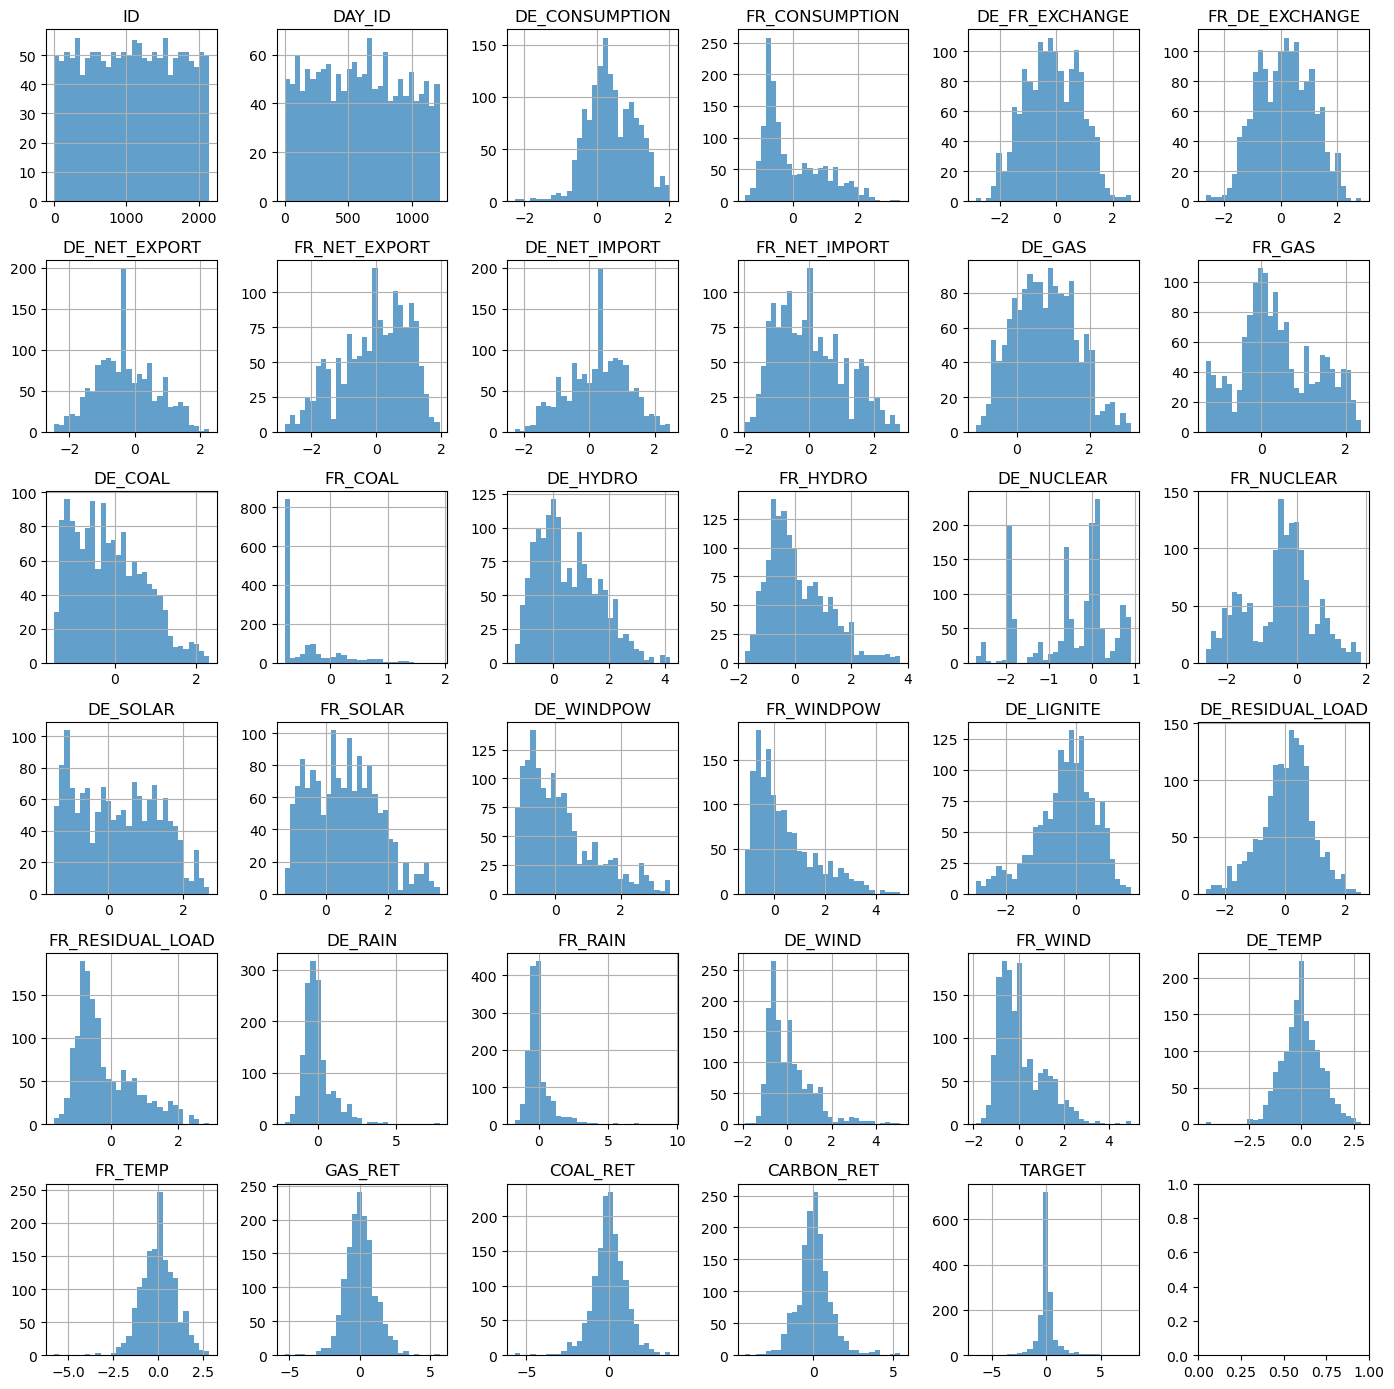

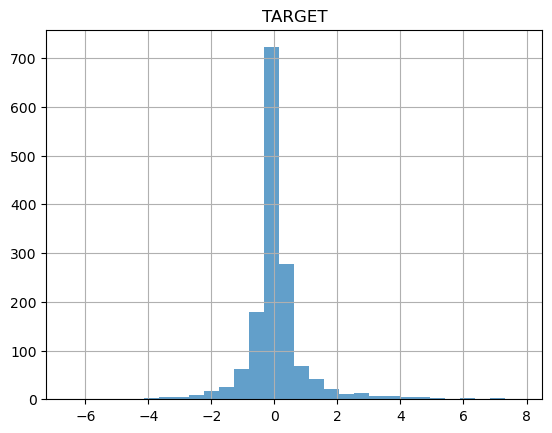

In [5]:
features = [feature for feature in df.columns if feature != "COUNTRY"]

nb_col = 6
nb_row = - (-len(features)//6)
fig, ax = plt.subplots(nb_row, nb_col, figsize=(14,14))

for i, feature in enumerate(features):
    i_col = i % nb_col
    i_row = i // nb_col
    ax1 = ax[i_row, i_col]
    
    ax1.set_title(feature)
    ax1.grid()
    df[feature].hist(bins= 30, ax=ax1, alpha=0.7)

plt.tight_layout()

fig, ax = plt.subplots()
ax1 = ax
y_df["TARGET"].hist(bins= 30, ax=ax1, alpha=0.7)
ax1.set_title("TARGET")

In [6]:
#Distribution data points by country
print("Nb of data points by country:")
print(df.COUNTRY.value_counts())

Nb of data points by country:
FR    851
DE    643
Name: COUNTRY, dtype: int64


We aim to predict prices for France and Germany. To better understand the factors influencing price in each country, we will plot the data separately. This allows us to evaluate whether the factors driving price variations are consistent or differ between the two countries.

In [7]:
#Divide the data by country, drop the country column and fill missing values with the mean
df_de = df[df['COUNTRY'] == 'DE']
df_de = df_de.drop(columns=['COUNTRY'])
df_de.fillna(df_de.mean(), inplace=True)

df_fr = df[df.COUNTRY == "FR"]
df_fr = df_fr.drop(columns=['COUNTRY'])
df_fr.fillna(df_fr.mean(), inplace=True)

### Plot of the distribution of each column by country

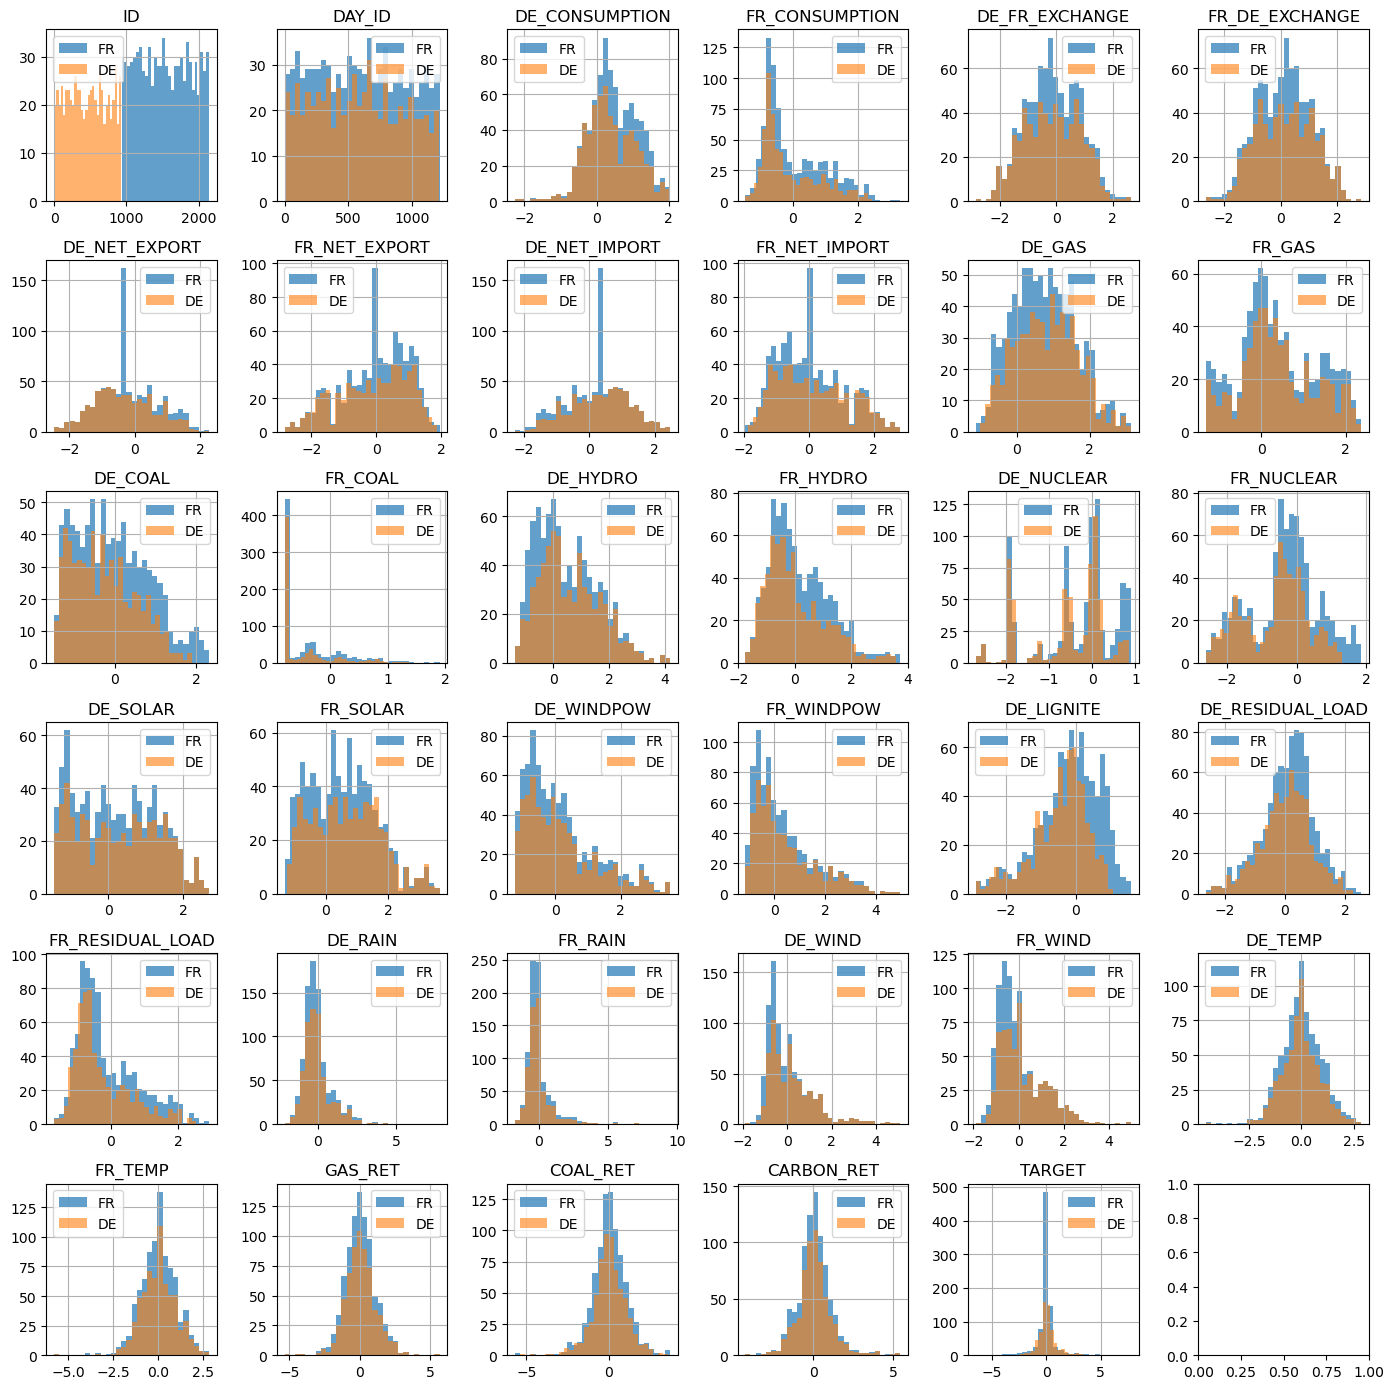

In [8]:
nb_col = 6
nb_row = - (-len(features)//6)
fig, ax = plt.subplots(nb_row, nb_col, figsize=(14,14))

for i, feature in enumerate(features):
    i_col = i % nb_col
    i_row = i // nb_col
    ax1 = ax[i_row, i_col]
    
    ax1.set_title(feature)
    ax1.grid()
    df_fr[feature].hist(bins= 30, ax=ax1, alpha=0.7, label= "FR")
    df_de[feature].hist(bins= 30, ax=ax1, alpha=0.6, label= "DE")
    ax1.legend()

plt.tight_layout()

We observe that the **distributions of various features** are generally similar between **France** and **Germany**. However, it is notable that the data associated with **Germany** exhibit greater **variability** across several variables. This can be attributed to a more **comprehensive** and **dense database** on the French side.  

It could be relevant to separate the data into **two distinct sets** to develop **specific models** for each country. Indeed, the **economic differences** between France and Germany are significant and can influence their respective behaviors, particularly regarding **electricity prices**. These differences are attributable to several factors, including:  

- **The structure of the energy mix**: France relies heavily on **nuclear energy**, whereas Germany has gradually reduced its use of nuclear energy in favor of **renewable sources** such as wind and solar. This creates differing dynamics in electricity supply and **sensitivity to weather conditions**.  

- **Energy policies**: The energy strategies differ between the two countries, with a faster energy transition in **Germany**, accompanied by **subsidy and regulatory policies** to promote renewables. In France, dependence on nuclear energy leads to a policy focus on **supply stability**.  

- **Climatic and geographical conditions**: Climatic variations, such as differences in **temperature** and **precipitation**, differently affect energy consumption in each country. For instance, France may experience higher heating demand in winter, while Germany, with its significant **wind power infrastructure**, is more impacted by wind variations.  

These differences suggest that a single model might not adequately capture the unique dynamics of each country. Therefore, an approach using **separate models** for **France** and **Germany** could better reflect their economic and energy-specific characteristics.


### Analysis of Data Availability 

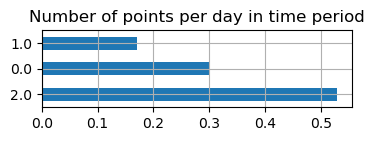

In [9]:
F = df.DAY_ID.value_counts().sort_index()
F = F.reindex(range(F.index.max()))
F = F.fillna(0)
F = F.value_counts()
F /= F.sum()
fig, ax = plt.subplots(figsize=(4,1))
ax1 = ax
ax1.set_title("Number of points per day in time period")
F.plot(kind="barh", ax=ax1)
ax1.grid()

The distribution of days based on data availability (53% of days with data for both countries, 30% without data, and the remainder with partial data available for only one of the two countries) provides important insights into the quality and representativeness of the sample used in our analysis.  

This distribution highlights the need to adopt strategies for handling missing data. Two approaches can be considered:  

- **Separate models by country** for days where data is available for only one country.  
- **Imputation or exclusion of days without data**, depending on their proportion and the potential impact on the analysis.  

These observations call for caution when interpreting the results, as irregular data availability may affect conclusions regarding temporal phenomena or direct comparisons between France and Germany.



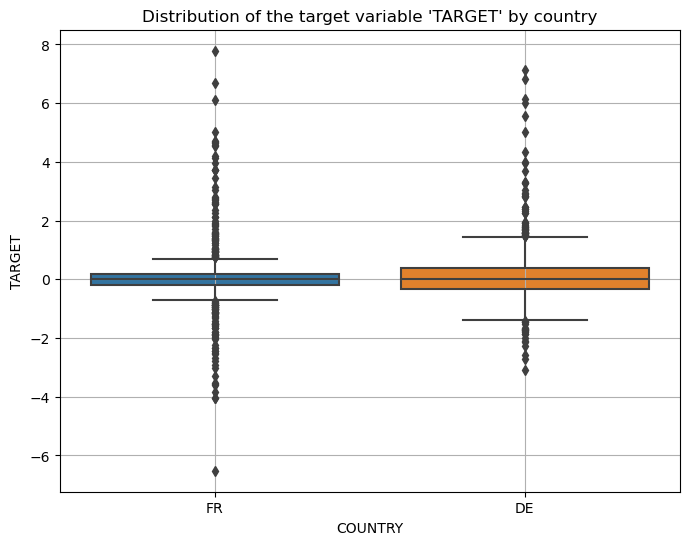

In [10]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="COUNTRY", y="TARGET", data=df)
plt.title("Distribution of the target variable 'TARGET' by country")
plt.xlabel("COUNTRY")
plt.ylabel("TARGET")
plt.grid(True)
plt.show()

Examining the distribution of the target variable for both countries reveals that the median is similar and close to zero for both France and Germany. This suggests that the target values are well **centered around zero** in both cases, indicating a generally balanced distribution of positive and negative values. This centrality can be interpreted as follows:  

- **Absence of trend bias**: The proximity of the median to zero for both countries suggests there is no systematic bias in the target values. In other words, the values do not skew significantly toward positive or negative levels, which is favorable for comparative analyses or symmetric predictive models.  
- **Quantile**: The interquartile range is slightly narrower for France, meaning that most TARGET values are more concentrated around the median compared to Germany. However, the presence of numerous outliers in Francesignificantly extends the range of extreme values, potentially requiring special handling to prevent undue influence on the models.  

#### Presence of Outliers  

Another striking aspect is the presence of **numerous outliers in the French data**, whereas extreme values are less frequent in Germany. This could reflect several dynamics:  

- **Increased variability in French data**: The higher frequency of extreme values in France might indicate greater volatility in the market or factors influencing the target variable.  
- **Influence of country-specific conditions**: France and Germany differ in infrastructure and energy mix (e.g., France's heavier reliance on nuclear energy compared to Germany). These structural differences could lead to extreme variations in certain energy indicators, especially during crises or periods of exceptional demand.  
- **Potential impact on predictive models**: These outliers could complicate modeling for the French data. Extreme values might influence the mean and variance, which could affect models sensitive to significant deviations. Techniques for managing outliers (e.g., data transformation or smoothing extreme values) may be necessary to enhance model robustness.  

#### Implications for Analysis  

The observations regarding centrality and outliers have several implications for analysis and modeling:  

1. **Strategies for managing extreme values**: The outliers in the French data may require special handling, such as outlier removal or the application of normalization or logarithmic transformation techniques to reduce their impact.  
2. **Country-specific approaches**: Since the target variable's distribution differs between France and Germany (particularly regarding outliers), it may be advisable to build separate models or apply differentiated preprocessing for each country.  
3. **Use of robust models**: In the presence of numerous outliers, more robust models, such as those based on the median (quantile regression) or ensemble algorithms (e.g., random forest or gradient boosting), might be better suited than standard linear models.  

#### Summary  

Although the French and German distributions of the target variable exhibit similar centrality, the higher frequency of outliers in France calls for a cautious approach. Proper handling of these outliers is essential to ensure the quality of results and the robustness of predictive models.


### Pearson's Correlation Matrix

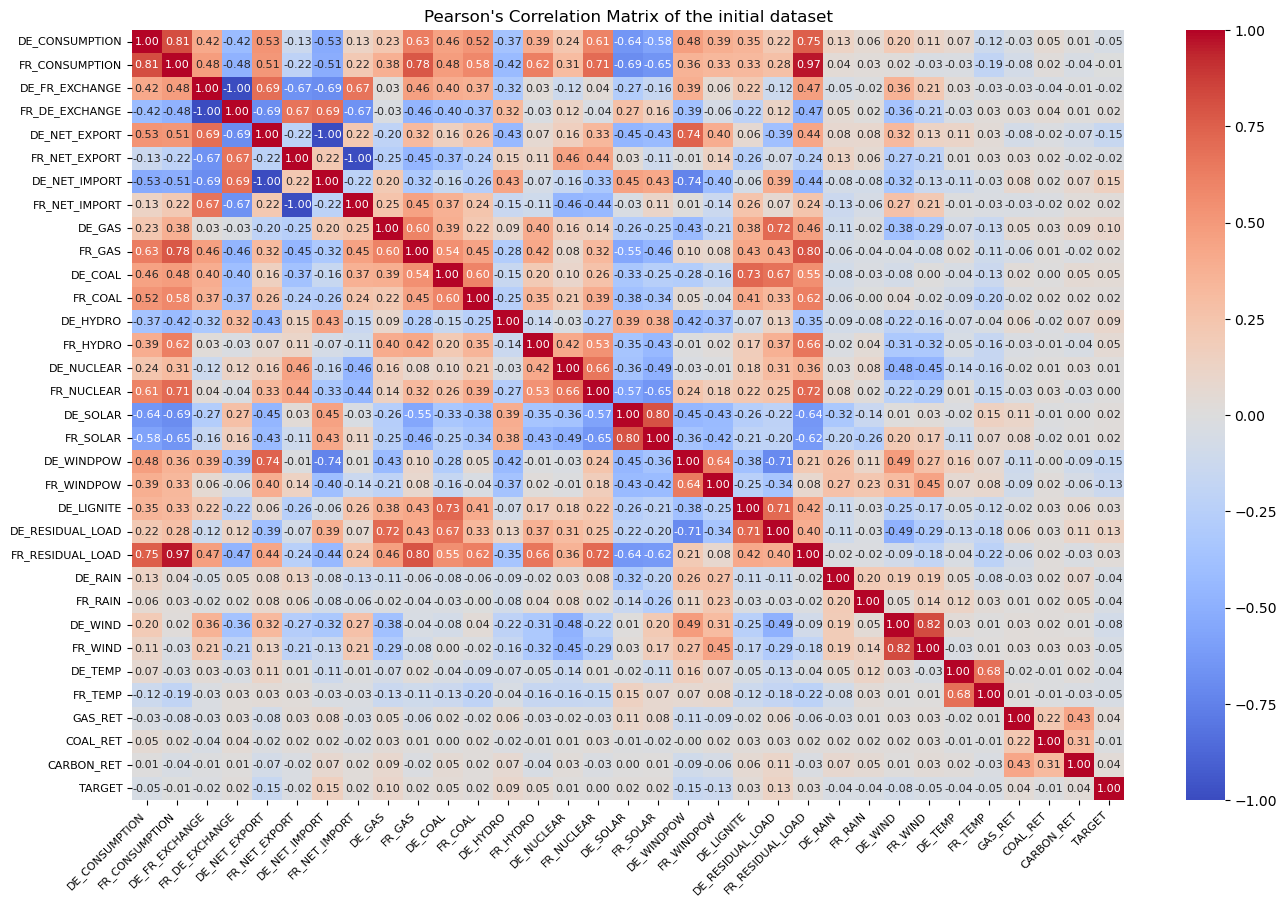

In [11]:
plt.figure(figsize=(16, 10))
df_cleaned = df_general.drop(columns=['ID', 'DAY_ID','COUNTRY'])
pearson_corr = df_cleaned.corr(method='pearson')
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 8})
plt.title("Pearson's Correlation Matrix of the initial dataset")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()


### Spearman's Correlation Matrix

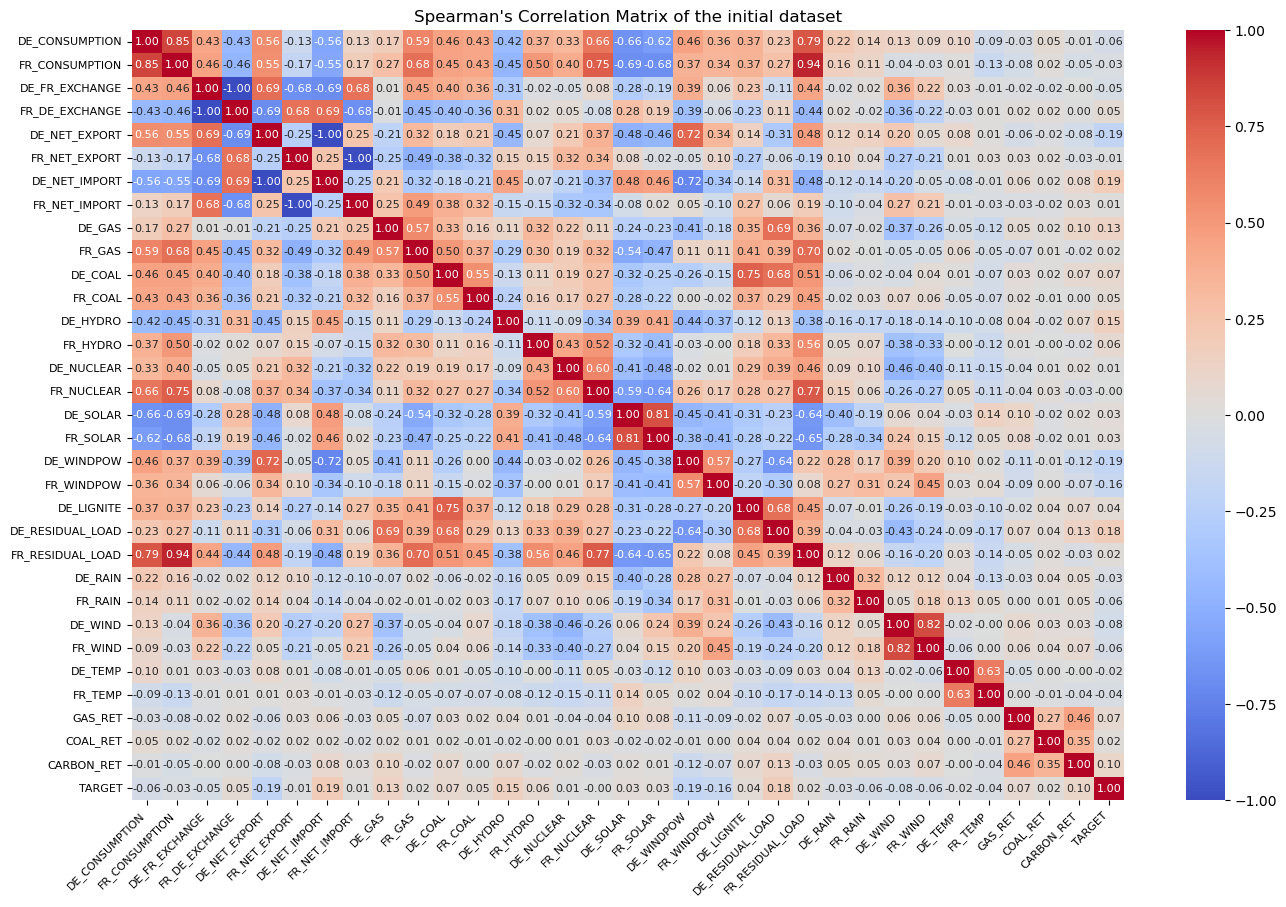

In [12]:
plt.figure(figsize=(16, 10))
df_cleaned = df.drop(columns=['ID', 'DAY_ID','COUNTRY'])
spearman_corr = df_cleaned.corr(method='spearman')
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 8})
plt.title("Spearman's Correlation Matrix of the initial dataset")   
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

By examining the **correlation matrices**, it is noticeable that the **Spearman** matrix shows stronger correlations with the '**TARGET**' row compared to the **Pearson** matrix. This difference arises because **Spearman** evaluates the **monotonic relationship** between variables, whether linear or not, based on their **ranks** rather than their absolute values. This method better captures relationships when the data is **nonlinear** or contains **outliers**, which might distort the **Pearson** correlation.


### Energy Production Distribution by Country

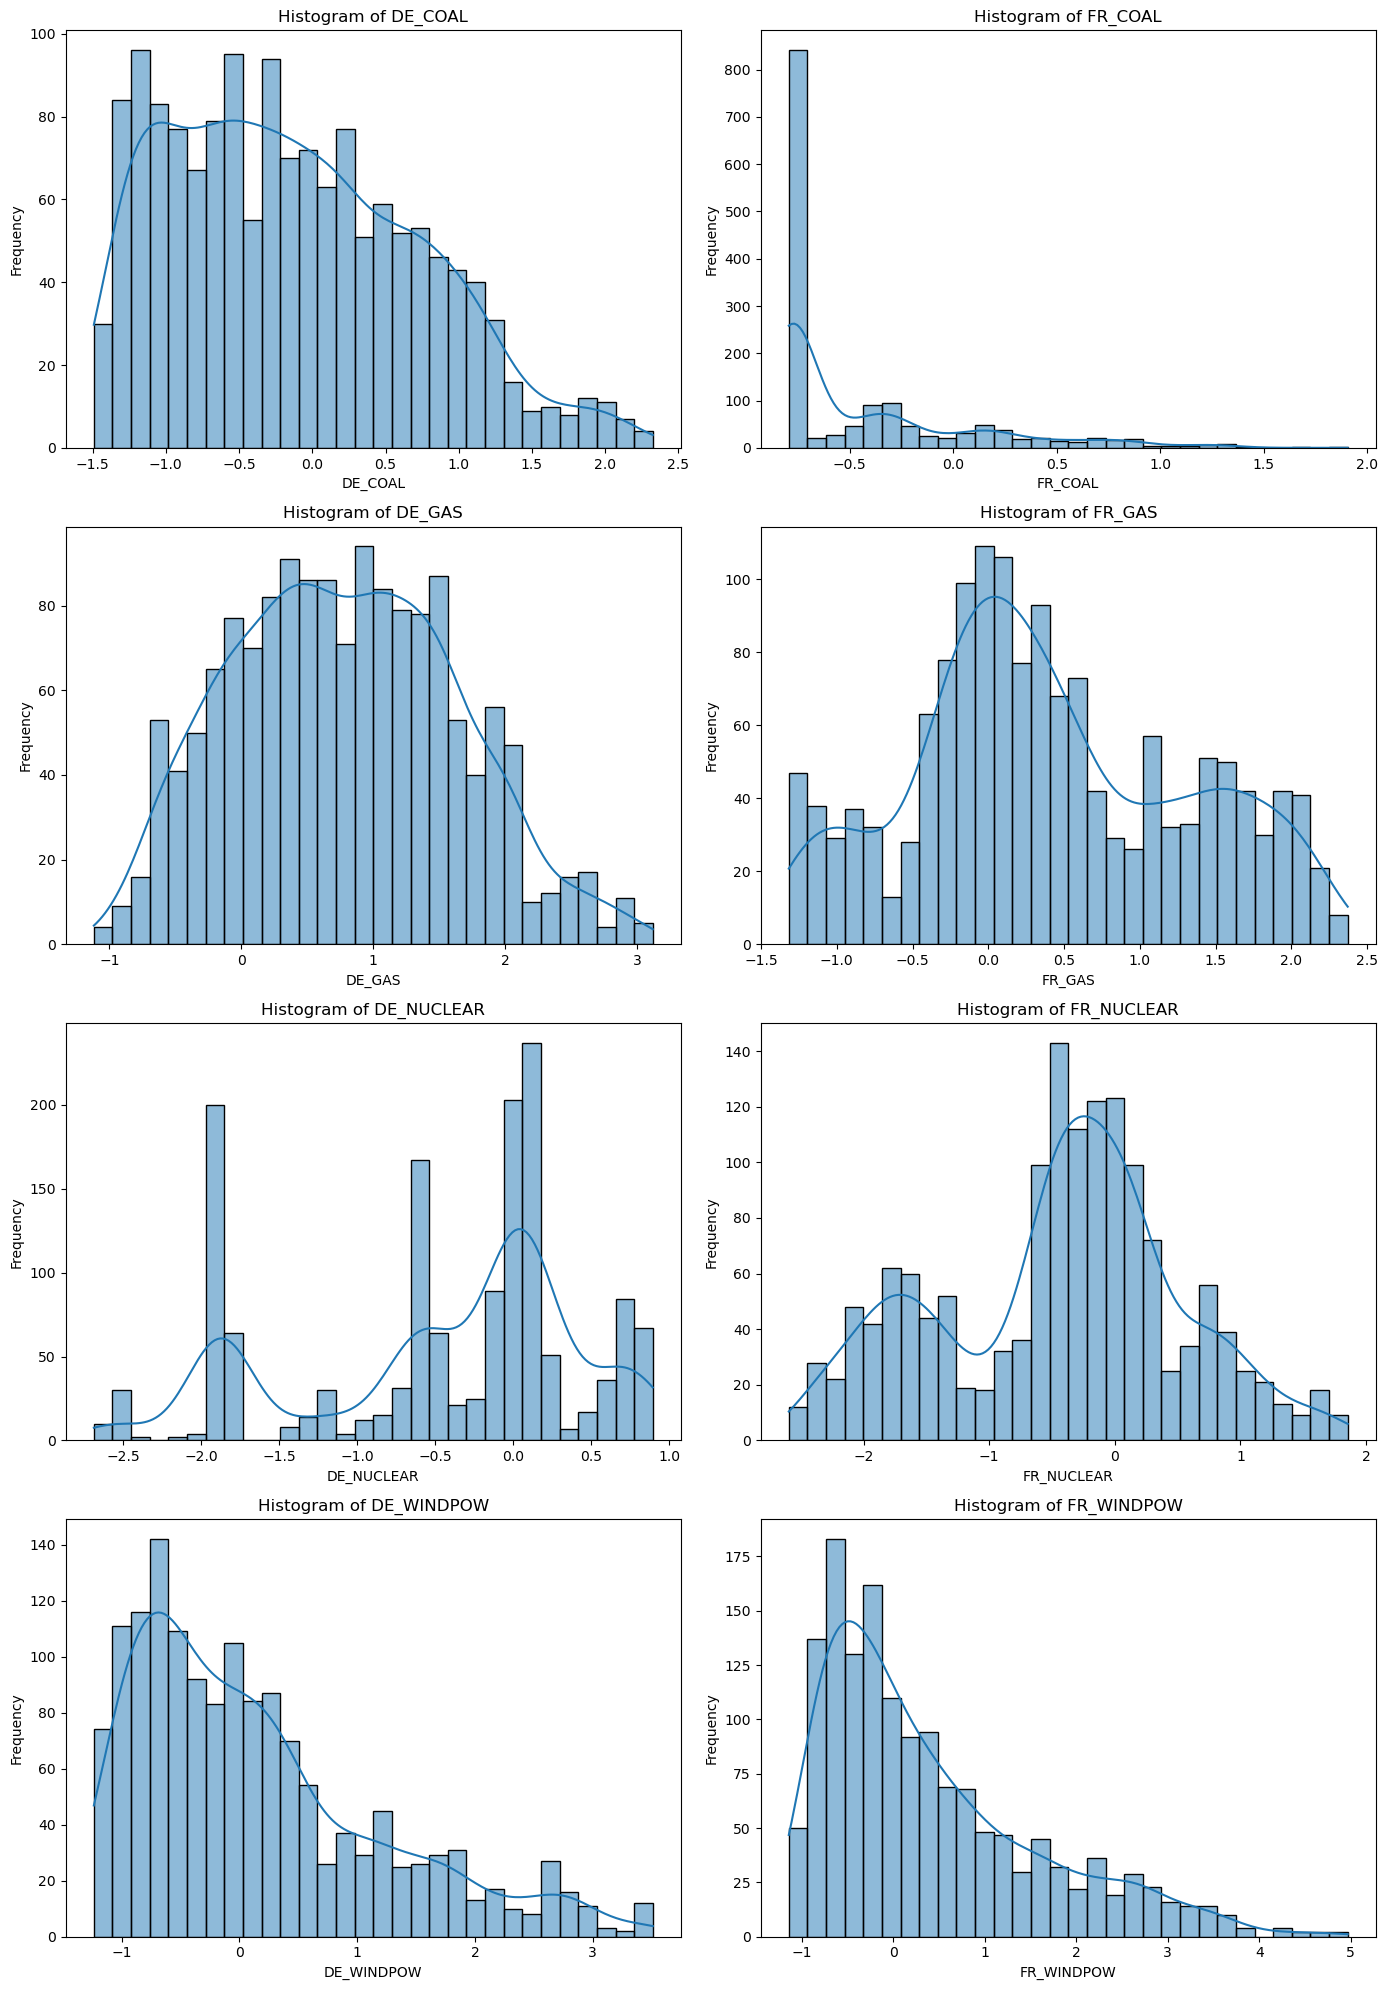

In [13]:
energy_sources = ['DE_COAL', 'FR_COAL', 'DE_GAS', 'FR_GAS', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_WINDPOW', 'FR_WINDPOW']

n_rows = len(energy_sources) // 2

plt.figure(figsize=(14, n_rows * 5))

for i, source in enumerate(energy_sources, 1):
    plt.subplot(n_rows, 2, i)
    sns.histplot(df_general[source], bins=30, kde=True)
    plt.title(f'Histogram of {source}')
    plt.xlabel(source)
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

These charts demonstrate that while certain energy sources, such as **wind power**, appear to be similarly distributed between **France** and **Germany**, the two countries clearly adopt **distinct energy strategies**. Notably, **France** stands out for its greater **stability** in **nuclear energy** production, while it remains relatively **weak** in terms of **coal** production.


### Spearman's Correlation Matrix for Data Related to France  

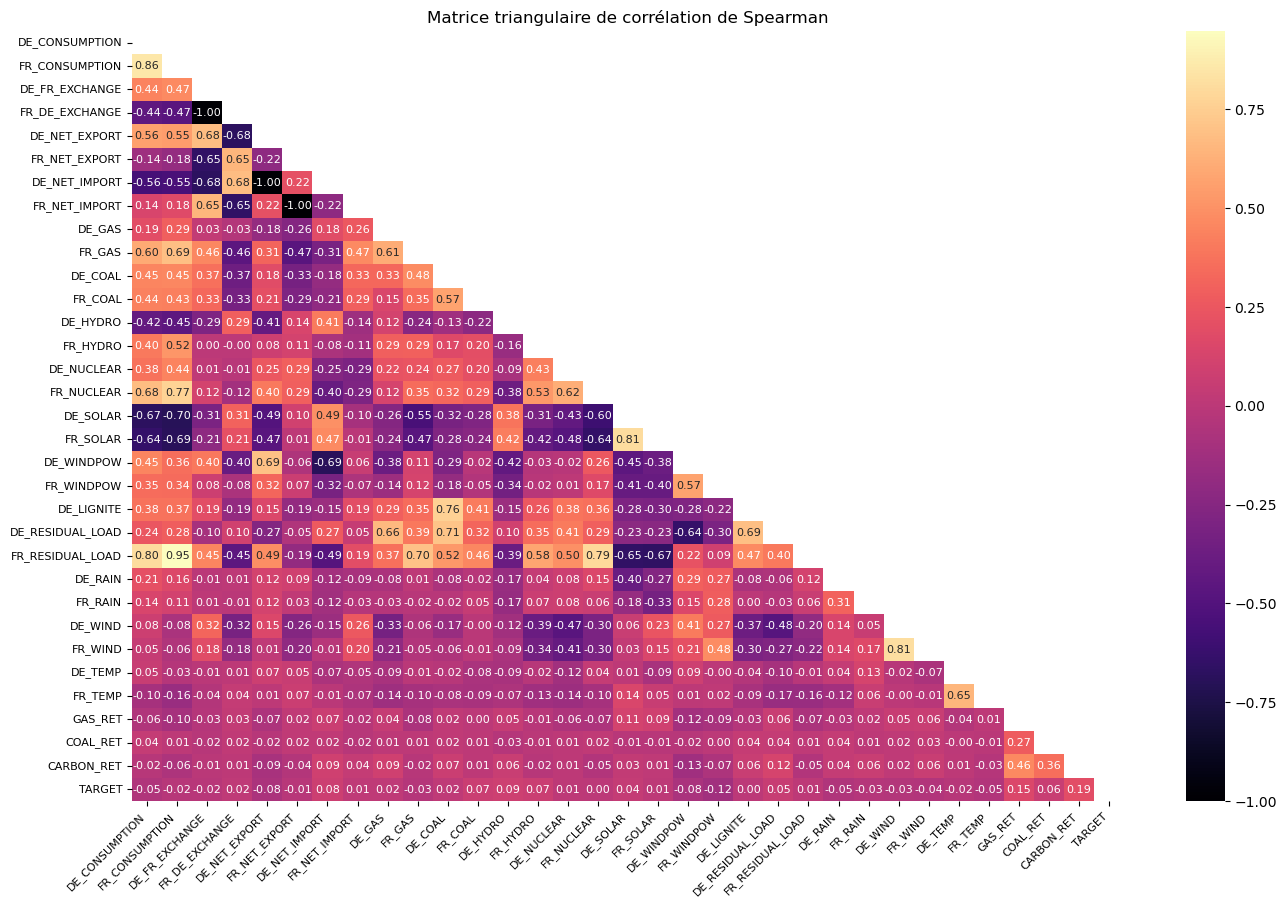

In [14]:
df_fr_cleaned=df_fr.drop(['ID','DAY_ID'],axis=1)
corr_matrix = df_fr_cleaned.corr()
plt.figure(figsize=(16, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
spearman_corr = df_fr_cleaned.corr(method='spearman')
sns.heatmap(spearman_corr, annot=True,mask=mask, fmt=".2f", cmap="magma", cbar=True, annot_kws={"size": 8})
plt.title("Matrice triangulaire de corrélation de Spearman")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

### Spearman Correlation Matrix for Data Related to Germany 

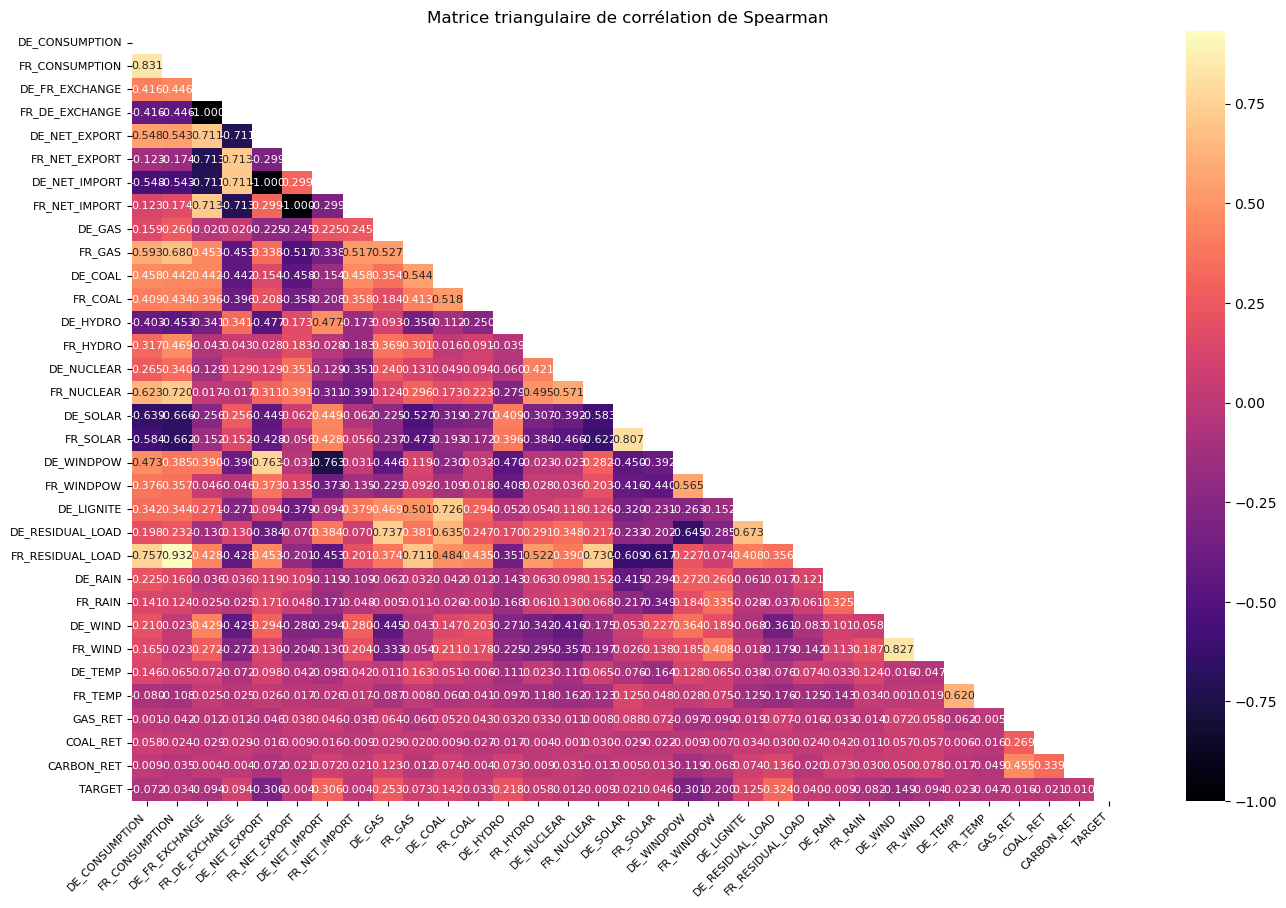

In [15]:
df_de_cleaned=df_de.drop(['ID','DAY_ID'],axis=1)
corr_matrix = df_de_cleaned.corr()
plt.figure(figsize=(16, 10))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

spearman_corr = df_de_cleaned.corr(method='spearman')
sns.heatmap(spearman_corr,mask=mask, annot=True, fmt=".3f", cmap="magma", cbar=True, annot_kws={"size": 8})
plt.title("Matrice triangulaire de corrélation de Spearman")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

## Model Evaluation

### Spearman's Correlation in Our Project

In this project, we aim to explain daily variations in electricity futures prices in Europe. Given the complex and non-linear relationships between factors like energy production, weather conditions, and market prices, **Spearman's correlation** is a suitable tool to evaluate our model's performance, alongside other metrics like R², MAE, and MSE.

### Why Use Spearman?

1. **Monotonicity**: The relationships between variables, such as the impact of gas prices on electricity prices, may be monotonic but non-linear. Spearman captures these monotonic trends where Pearson would fail.

2. **Robustness to Outliers**: Since the data can contain extreme values (e.g., sudden price spikes), Spearman is less sensitive to outliers, providing a more stable evaluation.

3. **Capturing Non-linear Relationships**: Variables like renewable energy production or electricity exchanges may have a non-linear effect. Spearman helps measure the monotonic relationship, even if it's not strictly linear.

### Spearman's Rank Correlation Formula

The Spearman rank correlation coefficient ($\rho$) is calculated as:

$$
\rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}
$$

Where:
- $d_i$ is the difference between the ranks of corresponding values in the two datasets.
- $n$ is the total number of data pairs.

### Additional Evaluation Metrics

- **R²**: This metric tells us the proportion of the variance in the target variable (electricity prices) explained by the model. A higher R² indicates a better fit.
  
- **MAE (Mean Absolute Error)**: This measures the average magnitude of errors in predictions, providing insight into how close the model's predictions are to the actual values, with smaller values being preferable.
  
- **MSE (Mean Squared Error)**: This gives us the squared average of the model's prediction errors, emphasizing larger errors more heavily. Like MAE, smaller values indicate better model performance.

Spearman's correlation is ideal for our project because it allows us to evaluate complex, non-linear trends in electricity prices while being robust to outliers. Alongside Spearman, we also use R², MAE, and MSE to provide a comprehensive view of our model's performance and ensure it captures the underlying dynamics of the electricity market effectively.


### K-Fold Cross-Validation and Model Evaluation

We use **k-fold cross-validation** to assess model performance on multiple data splits. The procedure involves:

1. **Data Preparation**: Features (`X`) and target (`y`) are separated from the dataset.
2. **K-Fold Cross-Validation**: Data is split into `k` folds, with each fold used for testing once.
3. **Standardization**: Features are scaled to have zero mean and unit variance using **StandardScaler**.
4. **Model Training**: The model is trained on the training data and predictions are made on the test set.
5. **Evaluation Metrics**: We calculate **Spearman's correlation**, **R²**, **MAE**, and **MSE** to assess model accuracy.
6. **Result Aggregation**: Metrics from each fold are collected in a DataFrame and returned.

This method provides a robust evaluation of the model’s performance across different subsets of data.


In [224]:
from sklearn.model_selection import KFold
# Import timeseries split
from sklearn.model_selection import TimeSeriesSplit

def kfoldCrossValidation(df, M, k):
    X = df.drop(columns=['ID', 'TARGET'], errors='ignore')
    y = df['TARGET']

    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    result = pd.DataFrame(columns=['Spearman', 'R2', 'MAE', 'MSE'])
  
    X = np.array(X)
    y = np.array(y)
  
    # Cross-validation loop
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]     
        y_train, y_test = y[train_index], y[test_index]

        # Data Standardization
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Training and prediction   
        M.fit(X_train, y_train)
        y_pred_test = M.predict(X_test)
    
        # Metrics calculation
        result_temp = pd.DataFrame([{
            'Spearman': spearmanr(y_test, y_pred_test).correlation, 
            'R2': M.score(X_test, y_test), 
            'MAE': np.mean(np.abs(y_test - y_pred_test)), 
            'MSE': np.mean((y_test - y_pred_test) ** 2)
        }])
    
        if not result_temp.isna().all().all():  
            result = pd.concat([result, result_temp], ignore_index=True)
    
    return result, y_test, y_pred_test


## Aggregation Model Function



Since we have separate models for each country, a function is required to aggregate the predictions from these two distinct machine learning models, each designed specifically to predict electricity prices in France and Germany. Each model is developed independently to account for the unique market dynamics, energy sources, and economic factors in each country.

### 1. Split the dataset by Country

The function split_dataset_by_country, which takes the original dataset as a parameter, enables splitting the dataset into two new datasets: df_fr (for the rows concerning France) and df_de (for the rows concerning Germany).

In [3]:
def split_dataset_by_country(df):
    df_fr = df[df['COUNTRY'] == 'FR']
    df_de = df[df['COUNTRY'] == 'DE']
    return df_fr, df_de

### 2. Drop irrelevent Columns

We decided, for each country (and thus for each model), to focus on the columns specifically related to each country. The function drop_irrelevant_columns allows us to remove the columns related to Germany from the df_fr dataset and the columns related to France from the df_de dataset.

In [2]:
def drop_irrelevant_columns(df, country):
    if country == 'FR':
        columns_to_drop = ['COUNTRY', 'DE_CONSUMPTION', 'DE_FR_EXCHANGE', 'FR_NET_EXPORT',
                           'DE_NET_EXPORT', 'DE_NET_IMPORT', 'DE_GAS', 'DE_COAL', 'DE_HYDRO',
                           'DE_NUCLEAR', 'DE_SOLAR', 'DE_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD',
                           'DE_RAIN', 'DE_WIND', 'DE_TEMP']
    elif country == 'DE':
        columns_to_drop = ['COUNTRY', 'FR_CONSUMPTION', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT',
                           'FR_NET_EXPORT', 'FR_NET_IMPORT', 'FR_GAS', 'FR_COAL', 'FR_HYDRO',
                           'FR_NUCLEAR', 'FR_SOLAR', 'FR_WINDPOW', 'FR_RESIDUAL_LOAD',
                           'FR_RAIN', 'FR_WIND', 'FR_TEMP']
        
    columns_to_drop = [col for col in columns_to_drop if col in df.columns]

    return df.drop(columns=columns_to_drop)

### 3. Fill Missing Values

Each dataset contains a certain number of missing values (as previously noted), and given the relatively limited amount of data, we couldn’t simply remove the rows with missing values. Therefore, we use the fill_missing_values function on df_fr and df_de individually to replace the missing values with the average of the column where the missing value is located.

In [1]:
def fill_missing_values(df):
    return df.fillna(df.mean())

### 4. Merging the results

Although we trained models and made predictions separately for France and Germany, the final model to submit at the end of the challenge is a single model. The function combine_results allows us to test the previous metrics, but this time on the entire set of our predictions.

In [228]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

def combine_results(y_test_fr, y_pred_fr, y_test_de, y_pred_de):
    y_pred_fr = pd.Series(y_pred_fr)
    y_pred_de = pd.Series(y_pred_de)
    y_test_de = pd.Series(y_test_de)
    y_test_fr = pd.Series(y_test_fr)
    
    y_true_combined = pd.concat([y_test_fr, y_test_de], axis=0)
    y_pred_combined = pd.concat([pd.Series(y_pred_fr), pd.Series(y_pred_de)], axis=0)
    combined_r2 = r2_score(y_true_combined, y_pred_combined)
    combined_mse = mean_squared_error(y_true_combined, y_pred_combined)
    combined_spearman = spearmanr(y_true_combined, y_pred_combined).correlation
    combined_mae = np.mean(np.abs(y_true_combined - y_pred_combined))   
    return combined_r2, combined_mse, combined_mae, combined_spearman

### 5. Final Function

Finally, we implement our global function, which sequentially utilizes the previously defined functions (1 to 4). This function provides the model's performance metrics for France, Germany, and the entire dataset.

The parameters "FeatureEngineering" and "DropIrrelevantColumns" will be applied later, and we will provide an explanation at that time.

In [229]:
def Final_model(df, model_fr, model_de,FeatureEngineering=None, DropIrrelevantColumns=True):

    # Step 1 : datasets splitting
    df_fr, df_de = split_dataset_by_country(df)

    if FeatureEngineering is None:
        if DropIrrelevantColumns: 
            df_fr = drop_irrelevant_columns(df_fr, 'FR')
            df_de = drop_irrelevant_columns(df_de, 'DE')
        else:
            df_fr = df_fr.drop(columns=['COUNTRY'])
            df_de = df_de.drop(columns=['COUNTRY'])

    else:
        df_fr = df_fr.drop(columns=['COUNTRY'])
        df_de = df_de.drop(columns=['COUNTRY'])
        df_fr, df_de = FeatureEngineering(df_fr,df_de)

    # Step 3 : Missing values replacement
    df_fr = fill_missing_values(df_fr)
    df_de = fill_missing_values(df_de)

    result_fr, y_test_fr, y_pred_fr = kfoldCrossValidation(df_fr, model_fr, 6)
    result_de, y_test_de, y_pred_de = kfoldCrossValidation(df_de, model_de, 6)

    # Step 8 : Combining the results and evaluating
    combined_r2, combined_mse, combined_mae, combined_spearman = combine_results(y_test_fr, y_pred_fr, y_test_de, y_pred_de)
    result_global = pd.DataFrame([{
        'R2': combined_r2,
        'MSE': combined_mse,
        'MAE': combined_mae,
        'Spearman': combined_spearman
    }])

    return result_fr, result_de, result_global

## First Model Using Linear Regression

### Model only with country separation

Building on our prior efforts, it’s now straightforward to test and evaluate different models.

Training of a model using simple LinearRegression

In [232]:
result_basic = Final_model(df, LinearRegression(), LinearRegression(), DropIrrelevantColumns=False)
result_basic[2]

,R2,MSE,MAE,Spearman
0,0.010782,1.532715,0.682185,0.211503


We observe that our Spearman correlation, R², and MSE scores are relatively low. However, it's crucial to consider the context. In financial markets, price movements are influenced by thousands of factors with complex, non-linear relationships, making it nearly impossible to develop a model that fully explains electricity prices today. For reference, the best model from the ENS QRT challenge addressing this problem achieved a Spearman correlation of 0.6. Our objective is to enhance these evaluation metrics as much as possible.

Display the results by country:

In [233]:
print("Results for France:")
print(result_basic[0],"\n")
print("Mean results for France:")
result_basic[0].mean()

Results for France:
   Spearman        R2       MAE       MSE
0 -0.011796 -0.110041  0.595154  1.381342
1  0.186548  0.039624  0.589289  0.975034
2  0.146556 -0.109504  0.410868  0.617653
3  0.048909 -0.060304  0.512791  0.785510
4  0.240920  0.011888  0.614186  1.120075
5  0.112233 -0.006267  0.660364  1.574673 

Mean results for France:


Spearman    0.120562
R2         -0.039101
MAE         0.563775
MSE         1.075714
dtype: float64

In [234]:
print("Results for Germany:")
print(result_basic[1],"\n")
print("Mean results for Germany:")
result_basic[1].mean()

Results for Germany:
   Spearman        R2       MAE       MSE
0  0.413101  0.027546  0.609758  1.033928
1  0.238063 -0.032239  0.671632  1.151835
2  0.393190  0.070116  0.568079  0.693152
3  0.358696  0.054072  0.591838  0.879387
4  0.350663  0.028436  0.695819  1.141123
5  0.344727  0.033027  0.710940  1.477424 

Mean results for Germany:


Spearman    0.349740
R2          0.030160
MAE         0.641344
MSE         1.062808
dtype: float64

As observed previously, it comes as no surprise that the German model outperforms the French one. This aligns with our earlier findings, where the features in the German dataset exhibited higher Spearman and Pearson correlation scores compared to those in the French dataset. Consequently, our model demonstrates better performance in Germany than in France.

### Model with separation and deleting of useless column for each country

Next, we explore whether the model's performance improves when features specific to France are removed for the German model, and vice versa. This is accomplished using the `DropIrrelevantColumns` function, which handles the removal of these features.

In [235]:
result = Final_model(df,LinearRegression(), LinearRegression(), DropIrrelevantColumns=True)
print("Results for the overall data:")
result[2]

Results for the overall data:


,R2,MSE,MAE,Spearman
0,0.021398,1.516266,0.660968,0.226606


We observe a slightly improved score after applying this approach, so we will retain it for the remainder of the project.

Results for each Country

In [26]:
print("Results for France:")
print(result[0],"\n")
print("Mean results for France:")
result[0].mean()

Results for France:
   Spearman        R2       MAE       MSE
0  0.095132 -0.021942  0.540903  1.271712
1  0.110415 -0.010931  0.581281  1.026360
2  0.142700 -0.045810  0.383076  0.582195
3  0.066466 -0.056812  0.484296  0.782923
4  0.184465  0.000525  0.574336  1.132955
5  0.123698 -0.007099  0.638691  1.575974 

Mean results for France:


Spearman    0.120479
R2         -0.023678
MAE         0.533764
MSE         1.062020
dtype: float64

In [27]:
print("Results for Germany:")
print(result[1],"\n")
print("Mean results for Germany:")
result[1].mean()

Results for Germany:
   Spearman        R2       MAE       MSE
0  0.457772  0.062252  0.597822  0.997028
1  0.228090  0.005428  0.663708  1.109805
2  0.385186  0.079801  0.566646  0.685932
3  0.358412  0.090473  0.588213  0.845547
4  0.383099  0.044765  0.691887  1.121945
5  0.392474  0.059209  0.690282  1.437422 

Mean results for Germany:


Spearman    0.367506
R2          0.056988
MAE         0.633093
MSE         1.032946
dtype: float64

## Feature engineering

We want to add more columns to create more precise models so we will do some feature engineering 

We can compute rolling statistics to capture trends and fluctuations over time. 
The rolling mean smooths the data to highlight long-term trends, while the rolling standard deviation measures volatility and variability within specific time windows (weekly and monthly). 
The slope, calculated using linear regression on rolling windows, captures the rate of change or trend direction, helping to identify whether values are generally increasing or decreasing over time.

In [28]:
# Function to calculate rolling statistics (mean, std, median, min, max, slope) for DE_ and FR_ columns
def add_statistics(df, variables, windows):
    def slope(y):
        return np.polyfit(range(len(y)), y, 1)[0] if len(y) > 0 else np.nan
    
    df.order = df.sort_values(by='DAY_ID')
    
    for var in variables:
        for window in windows:
            for country in ['DE_', 'FR_']:
                col = f'{country}{var}'
                df[f'{col}_MEAN_{window}D'] = df[col].rolling(window=window).mean()
                df[f'{col}_STD_{window}D'] = df[col].rolling(window=window).std()
                df[f'{col}_MEDIAN_{window}D'] = df[col].rolling(window=window).median()
                df[f'{col}_MIN_{window}D'] = df[col].rolling(window=window).min()
                df[f'{col}_MAX_{window}D'] = df[col].rolling(window=window).max()
                df[f'{col}_SLOPE_{window}D'] = df[col].rolling(window=window).apply(slope, raw=True)
    return df


Then we can use technical indicators widely use in finance like volatility and moving averages that are used to analyze time-series data. Volatility, typically measured by rolling standard deviation, helps quantify the level of fluctuation or uncertainty in the data. Moving averages, especially exponential moving averages (EMA), are used to smooth short-term fluctuations and highlight long-term trends or cycles, making it easier to detect underlying patterns in the data.

In [29]:
def add_indicators(df):
    for commodity in ['GAS_RET', 'COAL_RET', 'CARBON_RET']:
        df[f'{commodity}_VOLATILITY_WEEKLY'] = df[commodity].rolling(window=7).std()
        df[f'{commodity}_VOLATILITY_MONTHLY'] = df[commodity].rolling(window=30).std()
        df[f'{commodity}_EMA_MONTHLY'] = df[commodity].ewm(span=30, adjust=False).mean()
    
    return df

Finally we can add column specific with this domain area such as energy ratios, weather effects, and clustering, wich will provide further insights into underlying patterns. Weather effects, such as temperature or wind, are crucial in energy demand prediction, as they directly influence consumption and production.

In [30]:
# Function to add energy source ratios and effects
def add_energy(df):
    energy_sources = ['GAS', 'COAL', 'HYDRO', 'NUCLEAR', 'SOLAR', 'WINDPOW']
    
    for country in ['DE_', 'FR_']:
        total_energy = sum(df[f'{country}{source}'] for source in energy_sources)
        
        for source in energy_sources:
            df[f'{country}{source}_RATIO'] = df[f'{country}{source}'] / total_energy

        df[f'{country}WIND_SOLAR'] = df[f'{country}WINDPOW'] + df[f'{country}SOLAR']
        df[f'{country}TEMP_EFFECT'] = df[f'{country}TEMP'] * df[f'{country}CONSUMPTION']
        df[f'{country}WIND_EFFECT'] = df[f'{country}WIND'] * df[f'{country}WINDPOW']
        df[f'{country}SOLAR_EFFECT'] = (df[f'{country}SOLAR'] / df[f'{country}TEMP']).replace([np.inf, -np.inf], np.nan).fillna(0)
    
    return df

Now that we have rearrange all our functions to add columns we can create a single function that call the others

In [31]:
# Main function to add custom features by combining all the previous functions
def add_columns(df):
    periods=[7, 30]# Weekly and Monthly
    variables = ['CONSUMPTION', 'GAS', 'COAL', 'HYDRO', 'NUCLEAR', 'SOLAR', 'WINDPOW', 'TEMP', 'RAIN', 'WIND']

    df=add_statistics(df, variables, periods)
    df=add_energy(df)
    df=add_indicators(df)
    
    df.fillna(df.mean(), inplace=True)
    return df

The following function calculates the correlation matrix and selects features that are either highly correlated with each other or have low correlation with the target variable. It combines both conditions to decide which features to drop

In [32]:
def select_features_based_on_correlation(df, target_column, multicollinear_threshold, correlation_threshold):
    # Calculate the Spearman correlation matrix because it is the metric that we choose
    corr_matrix=df.corr(method='spearman')
    # Identify columns that are highly correlated with each other
    # (excluding the target variable correlation)
    high_corr_var=np.where(corr_matrix > multicollinear_threshold)
    high_corr_var=[(corr_matrix.index[x], corr_matrix.columns[y]) 
                     for x, y in zip(*high_corr_var) 
                     if x!=y and x < y]
    # Extract the names of columns to drop based on multicollinearity
    multicollinear_features=set([item for sublist in high_corr_var for item in sublist])
    # Identify features that have a low correlation with the target variable
    low_corr_with_target=corr_matrix[target_column][abs(corr_matrix[target_column]) < correlation_threshold].index.tolist()
    # Combine features to drop due to multicollinearity and low correlation with target
    features_to_drop=multicollinear_features.union(low_corr_with_target)
    # Determine the final list of features to keep
    features_to_keep=[feature for feature in df.columns if feature not in features_to_drop and feature!=target_column]
    
    return features_to_keep

Here, we filter the dataset for France (COUNTRY == 'FR'), remove certain columns, and keep some of the original columns, which can still have an impact on our prediction even if they are less correlated than the ‘artificial’ columns from feature engineering.

### Final function that will be used for the feature engineering

In [239]:
def FeatureEngineering(df_fr, df_de, df_fr_test=None, df_de_test=None):

    # We retain the columns in the main dataset, but not the columns with a high correlation with the others or a lower correlation with TARGET
    col_fr_best = select_features_based_on_correlation(df_fr, 'TARGET', 0.93, 0.08)

    # Select columns that do not start with 'DE' (to avoid mixing German data)
    df_no_de = df_fr[df_fr.columns[~df_fr.columns.str.startswith('DE')]]
    col_fr = [col for col in df_no_de.columns if col in col_fr_best]
    df_fr.fillna(df_fr.mean(), inplace=True)
    df_fr_test.fillna(df_fr_test.mean(), inplace=True) if df_fr_test is not None else None

    # We retain the columns in the main dataset, but not the columns with a high correlation with the others or a lower correlation with TARGET
    col_de_best = select_features_based_on_correlation(df_de, 'TARGET', 0.93, 0.08)

    # Select columns that do not start with 'FR' (to avoid mixing French data)
    df_no_fr = df_de[df_de.columns[~df_de.columns.str.startswith('FR')]]
    col_de = [col for col in df_no_fr.columns if col in col_de_best]
    df_de.fillna(df_de.mean(), inplace=True)
    df_de_test.fillna(df_de_test.mean(), inplace=True) if df_de_test is not None else None

    original_fr = df_fr[col_fr]
    original_de = df_de[col_de]

    # Apply feature engineering
    df_fr = add_columns(df_fr)
    df_de = add_columns(df_de)

    if df_fr_test is not None:
        original_fr_test = df_fr_test[col_fr]
        df_fr_test = add_columns(df_fr_test)
    
    if df_de_test is not None:
        original_de_test = df_de_test[col_de]
        df_de_test = add_columns(df_de_test)

    # Select the best columns based on correlation
    best_features_fr = select_features_based_on_correlation(df_fr, 'TARGET', 0.8, 0.08)
    best_features_de = select_features_based_on_correlation(df_de, 'TARGET', 0.8, 0.15)

    # Keep the selected columns while adding the original columns
    df_fr = pd.concat([original_fr, df_fr[best_features_fr+['TARGET']]], axis=1)
    df_de = pd.concat([original_de, df_de[best_features_de+['TARGET']]], axis=1)

    df_fr_test = pd.concat([original_fr_test, df_fr_test[best_features_fr]], axis=1) if df_fr_test is not None else None
    df_de_test = pd.concat([original_de_test, df_de_test[best_features_de]], axis=1) if df_de_test is not None else None

    if df_fr_test is not None and df_de_test is not None:
        return df_fr, df_de, df_fr_test, df_de_test
    else:
        return df_fr, df_de

## Model Using LinearRegression and Feature Engineering

#### Linear Regression

In [34]:
result = Final_model(df,LinearRegression(), LinearRegression(),FeatureEngineering, DropIrrelevantColumns=True)
result[2]

,R2,MSE,MAE,Spearman
0,0.035883,1.493822,0.636906,0.297179


The Speaman Correlation improved a lot from 0.22 to almost 0.3. The features engineering give a better performance to our Model.

In [35]:
result[0].mean()

Spearman    0.169852
R2         -0.022708
MAE         0.518298
MSE         1.054078
dtype: float64

In [36]:
result[1].mean()

Spearman    0.370877
R2          0.069031
MAE         0.626483
MSE         1.019218
dtype: float64

## Model Using RandomForestRegressor

Let's experiment with the **RandomForestRegressor**, which is highly effective for capturing non-linear relationships. To maximize its potential, we use **GridSearchCV**, a technique that systematically tests multiple combinations of hyperparameters for the Random Forest and selects the best configuration for our model.

In [240]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf = RandomForestRegressor(random_state=42)

grid_search_1 = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search_2 = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)

result = Final_model(df, grid_search_1, grid_search_2, FeatureEngineering, True)


NameError: name 'select_features_based_on_correlation' is not defined

In [223]:
print("GridSearchCV_1 coeffcients :", grid_search_1.best_params_)
print("GridSearchCV_2 coeffcients :", grid_search_2.best_params_)

NameError: name 'grid_search_1' is not defined

In [39]:
result[2]

,R2,MSE,MAE,Spearman
0,0.068241,1.443687,0.637773,0.304045


The **RandomForestRegressor** demonstrates a markedly higher Spearman Correlation score compared to **Linear Regression**, highlighting its enhanced ability to capture relationships within the data. Additionally, it achieves a notable improvement in both the **R² score** (0.06 versus 0.035) and **MSE**, further underscoring its effectiveness. These metrics indicate that the RandomForestRegressor is better equipped to capture underlying patterns, particularly non-linear relationships. The model’s higher R² and lower MSE reflect its superior capacity to explain variance in the data and deliver more accurate predictions. This performance emphasizes the advantages of employing a non-linear model like Random Forest, showcasing its robustness in predictive power and generalization.

Moving forward, we plan to improve the model’s performance by fine-tuning the **RandomForestRegressor** and optimizing feature engineering specifically tailored to this model. These enhancements are expected to further reinforce its advantage over Linear Regression, particularly in terms of Spearman Correlation, by fully leveraging its ability to capture non-linear relationships between variables and the target. Additionally, we intend to investigate more advanced and sophisticated models to drive further gains in predictive accuracy and overall performance.

## Output for Challenge submission

Since our project is part of a challenge, we need to apply our model to a X_test dataset and submit the predictions we make. The function below handles this process, ensuring that the model's predictions are properly generated and ready for submission.

In [400]:
def output_for_submission(df, X_test_df,model_fr,model_de, feature_engineering = False):
    
    # Step 1 : datasets splitting
    df_fr, df_de = split_dataset_by_country(df)
    df_fr_test, df_de_test = split_dataset_by_country(X_test_df)

    start_df_fr_test = df_fr_test.copy()
    start_df_de_test = df_de_test.copy()


    if feature_engineering == False:
        #Step 2: Dropping unnecessary columns   
        df_fr = drop_irrelevant_columns(df_fr, 'FR')
        df_de = drop_irrelevant_columns(df_de, 'DE')
        df_fr_test = drop_irrelevant_columns(df_fr_test, 'FR')
        df_de_test = drop_irrelevant_columns(df_de_test, 'DE')

    else:
        df_fr = df_fr.drop(columns=['COUNTRY'])
        df_de = df_de.drop(columns=['COUNTRY'])

        df_fr_test = df_fr_test.drop(columns=['COUNTRY'])
        df_de_test = df_de_test.drop(columns=['COUNTRY'])

    # Step 3 : Missing values replacement
    df_fr = fill_missing_values(df_fr)
    df_de = fill_missing_values(df_de)

    df_fr_test = fill_missing_values(df_fr_test)
    df_de_test = fill_missing_values(df_de_test)

    if(feature_engineering):
        df_fr, df_de, df_fr_test, df_de_test = FeatureEngineering(df_fr,df_de, df_fr_test, df_de_test) 

    df_fr_scaled = StandardScaler().fit_transform(df_fr)
    df_de_scaled = StandardScaler().fit_transform(df_de)
    df_fr_scaled = pd.DataFrame(df_fr_scaled, columns=df_fr.columns)
    df_de_scaled = pd.DataFrame(df_de_scaled, columns=df_de.columns)
    df_fr_scaled.drop(columns=['TARGET'], inplace=True)
    df_de_scaled.drop(columns=['TARGET'], inplace=True)

    model_fr.fit(df_fr_scaled, df_fr['TARGET'])
    model_de.fit(df_de_scaled, df_de['TARGET'])

    df_fr_test_scaled = StandardScaler().fit_transform(df_fr_test)
    df_de_test_scaled = StandardScaler().fit_transform(df_de_test)
    df_fr_test_scaled = pd.DataFrame(df_fr_test_scaled, columns=df_fr_test.columns)
    df_de_test_scaled = pd.DataFrame(df_de_test_scaled, columns=df_de_test.columns)

    y_pred_fr = pd.DataFrame(model_fr.predict(df_fr_test_scaled))
    y_pred_de = pd.DataFrame(model_de.predict(df_de_test_scaled))

    y_pred_fr['ID'] = start_df_fr_test['ID'].values
    y_pred_de['ID'] = start_df_de_test['ID'].values

    #Rename columns
    y_pred_fr.columns = ['TARGET', 'ID']
    y_pred_de.columns = ['TARGET', 'ID']

    #Change the order of columns for the submition
    y_pred_fr = y_pred_fr[['ID', 'TARGET']]
    y_pred_de = y_pred_de[['ID', 'TARGET']]

    y_pred = pd.concat([y_pred_fr, y_pred_de], axis=0)
   
    return y_pred

In [401]:
output = output_for_submission(df, X_test_df,LinearRegression(), LinearRegression(),True)

In [ ]:
output.to_csv('submission.csv', index=False)

## Future of the Project 🚀

The future of the project focuses on improving our model's performance and prediction accuracy. We plan to **fine-tune the RandomForest** 🌲, as it has the potential to capture non-linear relationships between the features and the target variable, which should give it a bigger edge over linear regression 📉. 

Additionally, we will explore more sophisticated models 🧠, such as **ensemble methods**, **gradient boosting**, and **neural networks** 🤖, to push the performance even further. As we continue, we’ll refine the **feature engineering** 🔧 process, optimize **hyperparameters** ⚙️, and incorporate **domain-specific insights** 📊 to enhance the model’s robustness and reliability.

Our ultimate goal 🎯 is to create a predictive model that can effectively handle the complex dynamics of the problem and achieve higher accuracy in forecasting 🌟.


In [13]:

def get_best_grid_parameters(data,model,parametre, FeatureEngineering=None, DropIrrelevantColumns=True):

    # Step 1 : datasets splitting
    df_fr, df_de = split_dataset_by_country(data)

    if FeatureEngineering is None:
        if DropIrrelevantColumns: 
            df_fr = drop_irrelevant_columns(df_fr, 'FR')
            df_de = drop_irrelevant_columns(df_de, 'DE')
        else:
            df_fr = df_fr.drop(columns=['COUNTRY'])
            df_de = df_de.drop(columns=['COUNTRY'])

    else:
        df_fr = df_fr.drop(columns=['COUNTRY'])
        df_de = df_de.drop(columns=['COUNTRY'])
        df_fr, df_de = FeatureEngineering(df_fr,df_de)

    # Step 3 : Missing values replacement
    df_fr = fill_missing_values(df_fr)
    df_de = fill_missing_values(df_de)
    
    grid1= GridSearchCV(estimator=model, param_grid=parametre, cv=5, n_jobs=1)
    grid2= GridSearchCV(estimator=model, param_grid=parametre, cv=5, n_jobs=1)
    
    X_fr=df_fr.drop('TARGET', axis=1)
    X_de=df_de.drop('TARGET', axis=1)
    y_fr=df_fr['TARGET']
    y_de=df_de['TARGET']
    
    #X_train_fr, X_test_fr, y_train_fr, y_test_fr = train_test_split(X_fr, y_fr, test_size=0.2, random_state=42)
    #X_train_de, X_test_de, y_train_de, y_test_de = train_test_split(X_de, y_de, test_size=0.2, random_state=42)
    
    grid1.fit(X_fr,y_fr)
    grid2.fit(X_de,y_de)
    
    best_params_fr = grid1.best_params_
    best_spearman_fr = grid1.best_score_
    
    best_params_de = grid2.best_params_
    best_spearman_de = grid2.best_score_
    
    print("Meilleur parametre pour la France : ",best_params_fr)
    print("Meilleur spearman pour la France : ",best_spearman_fr)
    print("Meilleur parametre pour l'Allemange : ",best_params_de)
    print("Meilleur spearman pour l'Allemagne : ",best_spearman_de)
    
    return best_spearman_fr, best_params_fr,best_spearman_de, best_params_de
    


In [14]:
# Chargement des données
X_df = pd.read_csv('X_train_NHkHMNU.csv', delimiter=',')
y_df = pd.read_csv('y_train_ZAN5mwg.csv', delimiter=',')

# Fusion des données d'entraînement sur la colonne 'ID'
df = pd.merge(X_df, y_df, on='ID')


In [15]:
df

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445,0.028313
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365,-0.112516
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952,-0.180840
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948,-0.260356
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378,-0.071733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,459,809,DE,1.529204,1.106682,-1.855327,1.855327,-0.218658,1.450426,0.218658,...,NaN,NaN,NaN,NaN,NaN,NaN,0.876984,0.819520,1.320373,-0.172597
1490,1674,887,FR,1.618582,1.752840,0.611392,-0.611392,0.449153,-0.152146,-0.449153,...,NaN,NaN,NaN,NaN,NaN,NaN,0.932633,-0.085690,0.356356,-0.063546
1491,748,1083,DE,0.856399,0.489199,-0.255778,0.255778,-1.531544,-0.829568,1.531544,...,0.207905,0.404763,-0.594595,0.894011,0.256338,0.402316,-1.112899,-0.237835,0.067152,0.151797
1492,1454,1133,FR,0.560689,-0.343777,-0.830239,0.830239,-0.304856,1.210230,0.304856,...,-0.682815,-0.390304,-0.972088,-1.501930,1.215528,1.338708,0.962812,-5.392852,-0.843812,-0.640917


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
rf = RandomForestRegressor(random_state=42)

best_spearman_fr, best_params_fr,best_spearman_de, best_params_de = get_best_grid_parameters(df,rf,param_grid)

Meilleur parametre pour la France :  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Meilleur spearman pour la France :  -0.04733272851734007
Meilleur parametre pour l'Allemange :  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Meilleur spearman pour l'Allemagne :  0.02516266876645299


In [259]:
pip install optuna


     -------------------------------------- 364.4/364.4 kB 2.1 MB/s eta 0:00:00
     -------------------------------------- 233.5/233.5 kB 4.7 MB/s eta 0:00:00
     ---------------------------------------- 78.6/78.6 kB 4.3 MB/s eta 0:00:00


In [101]:
import optuna
from sklearn.metrics import mean_squared_error

In [247]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scipy.stats import spearmanr  # Pour calculer la corrélation de Spearman


In [157]:
def objectivefr(trial):
    # 1. Suggérer des hyperparamètres
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 128)

    # 2. Créer et entraîner le modèle
    model = create_nn_model(input_dim=X_train_fr.shape[1], learning_rate=lr)
    model.fit(X_train_fr, y_train_fr, batch_size=batch_size, epochs=10, verbose=0)

    # 3. Faire des prédictions sur les données de test
    y_pred_fr = model.predict(X_test_fr).flatten()

    # 4. Calculer la corrélation de Spearman
    spearman_corr, _ = spearmanr(y_test_fr, y_pred_fr)

    # Optuna maximise la valeur, donc on retourne -spearman_corr pour minimiser
    return -spearman_corr 

In [158]:
def objectivede(trial):
    # 1. Suggérer des hyperparamètres
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 128)

    # 2. Créer et entraîner le modèle
    model = create_nn_model(input_dim=X_train_de.shape[1], learning_rate=lr)
    model.fit(X_train_de, y_train_de, batch_size=batch_size, epochs=10, verbose=0)

    # 3. Faire des prédictions sur les données de test
    y_pred_de = model.predict(X_test_de).flatten()

    # 4. Calculer la corrélation de Spearman
    spearman_corr, _ = spearmanr(y_test_de, y_pred_de)

    # Optuna maximise la valeur, donc on retourne -spearman_corr pour minimiser
    return -spearman_corr

In [159]:
def create_nn_model(input_dim, learning_rate):
    """
    Crée un modèle de réseau de neurones avec des paramètres personnalisables.

    Args:
        input_dim (int): Nombre de caractéristiques en entrée.
        learning_rate (float): Taux d'apprentissage pour l'optimiseur.

    Returns:
        keras.Model: Modèle de réseau de neurones compilé.
    """
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))  # Régression (prédiction continue)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [160]:
# Chargement des données
X_df = pd.read_csv('X_train_NHkHMNU.csv', delimiter=',')
y_df = pd.read_csv('y_train_ZAN5mwg.csv', delimiter=',')

# Fusion des données d'entraînement sur la colonne 'ID'
df = pd.merge(X_df, y_df, on='ID')

In [161]:
# Fonction pour séparer les datasets par pays
def split_dataset_by_country(dataframe):
    df_fr = dataframe[dataframe['COUNTRY'] == 'FR']
    df_de = dataframe[dataframe['COUNTRY'] == 'DE']
    return df_fr, df_de

In [162]:
# Séparer les datasets par pays
df_fr, df_de = split_dataset_by_country(df)

In [163]:
df_fr = fill_missing_values(df_fr)
df_de = fill_missing_values(df_de)


C:\Users\Dell\AppData\Local\Temp\ipykernel_58772\272810606.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return df.fillna(df.mean())


In [164]:
# Préservation des jeux de test originaux pour vérification ultérieure
#start_df_fr_test = df_fr_test.copy()
#start_df_de_test = df_de_test.copy()

In [165]:
df_fr = drop_irrelevant_columns(df_fr, 'FR')
df_de = drop_irrelevant_columns(df_de, 'DE')

In [166]:
# Extraire les cibles (TARGET) avant standardisation
y_fr = df_fr.pop('TARGET')
y_de = df_de.pop('TARGET')

In [167]:
# Standardisation des données
scaler_fr = StandardScaler()
scaler_de = StandardScaler()

In [168]:
y_fr.shape

(851,)

In [169]:
df_fr_scaled = pd.DataFrame(scaler_fr.fit_transform(df_fr), columns=df_fr.columns)
df_de_scaled = pd.DataFrame(scaler_de.fit_transform(df_de), columns=df_de.columns)

In [170]:
# Séparation des caractéristiques et cibles pour les jeux d'entraînement
X_fr = df_fr_scaled
X_de = df_de_scaled

In [171]:
df_fr_scaled.head()

,ID,DAY_ID,FR_CONSUMPTION,FR_DE_EXCHANGE,FR_NET_IMPORT,FR_GAS,FR_COAL,FR_HYDRO,FR_NUCLEAR,FR_SOLAR,FR_WINDPOW,FR_RESIDUAL_LOAD,FR_RAIN,FR_WIND,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,-1.357724,-1.124793,-0.489292,0.512307,-0.711986,-0.660487,1.280529,0.041648,0.143435,0.665574,-0.538079,-0.387729,-0.577358,-0.310296,-0.067282,0.274090,0.052968,-0.070488
1,1.465821,-0.277017,-1.100415,-0.108750,1.084866,0.032141,-0.700122,-0.921418,-1.875381,2.541992,-0.399987,-1.188627,-0.790462,0.804432,1.867554,-0.640599,-0.021313,-0.515700
2,1.111105,0.257512,2.063578,-1.217450,1.628494,1.864829,2.200753,0.583748,1.079852,-0.863090,-0.428856,2.206190,-0.335473,0.462661,0.114739,0.454560,0.646526,0.118755
3,-1.224351,0.633982,-0.690433,0.850714,-1.005071,-0.689779,0.218042,-0.910858,0.515126,0.169853,-0.789403,-0.476226,-0.446166,-1.040763,0.742437,0.188011,1.397860,2.317280
4,-0.035340,-0.374727,-0.847547,0.630222,0.168032,-0.098143,-0.726114,0.407359,-1.607016,1.425759,-0.517778,-0.838823,-0.216528,-0.946169,0.480202,0.779950,0.759782,0.957774


In [172]:
X_fr.shape

(851, 18)

In [173]:
# Séparation des jeux d'entraînement et de test (80% - 20%)
X_train_fr, X_test_fr, y_train_fr, y_test_fr = train_test_split(X_fr, y_fr, test_size=0.2, random_state=42)
X_train_de, X_test_de, y_train_de, y_test_de = train_test_split(X_de, y_de, test_size=0.2, random_state=42)

In [174]:
# Lancer Optuna pour l'optimisation
study = optuna.create_study(direction='maximize')  # On minimise la MSE
study.optimize(objectivefr, n_trials=100)  # 20 essais pour l'optimisation

# 3. Afficher les meilleurs hyperparamètres et la meilleure corrélation de Spearman
print("Meilleurs hyperparamètres pour la France :", study.best_params)
#print("Meilleure corrélation de Spearman :", -study.best_value) 

[I 2024-11-27 17:03:19,729] A new study created in memory with name: no-name-909d9189-a302-4faf-bcb7-f92a1253eda3


6/6 [==============================] - 0s 3ms/step


[I 2024-11-27 17:03:20,192] Trial 0 finished with value: 0.0484436415170615 and parameters: {'learning_rate': 0.00024108646215964324, 'batch_size': 100}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 3ms/step


[I 2024-11-27 17:03:20,662] Trial 1 finished with value: -0.1360153934861127 and parameters: {'learning_rate': 0.002094647735525852, 'batch_size': 77}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:21,496] Trial 2 finished with value: 0.009226731722186916 and parameters: {'learning_rate': 0.00021959846340193113, 'batch_size': 19}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 0s/step


[I 2024-11-27 17:03:22,057] Trial 3 finished with value: -0.028991785460792813 and parameters: {'learning_rate': 0.00018540252674877859, 'batch_size': 110}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:03:22,601] Trial 4 finished with value: -0.040817697949042525 and parameters: {'learning_rate': 0.00033129815762462575, 'batch_size': 104}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 566us/step


[I 2024-11-27 17:03:23,108] Trial 5 finished with value: -0.1255526709102579 and parameters: {'learning_rate': 0.0002436566893307231, 'batch_size': 88}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:03:23,666] Trial 6 finished with value: -0.08630096137290139 and parameters: {'learning_rate': 0.0008297876294336692, 'batch_size': 50}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:03:24,129] Trial 7 finished with value: -0.14142615344648996 and parameters: {'learning_rate': 0.00056349891164903, 'batch_size': 75}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 0s/step


[I 2024-11-27 17:03:24,809] Trial 8 finished with value: -0.01553737825751324 and parameters: {'learning_rate': 0.08679329610258332, 'batch_size': 99}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:25,272] Trial 9 finished with value: -0.13297085987397744 and parameters: {'learning_rate': 0.05766739311948026, 'batch_size': 101}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 3ms/step


[I 2024-11-27 17:03:25,725] Trial 10 finished with value: -0.11785952783951521 and parameters: {'learning_rate': 0.009883018988127825, 'batch_size': 126}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 3ms/step


[I 2024-11-27 17:03:26,422] Trial 11 finished with value: -0.03589653436565216 and parameters: {'learning_rate': 0.0019705798095667262, 'batch_size': 17}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:26,945] Trial 12 finished with value: -0.08290138652975461 and parameters: {'learning_rate': 0.00010165300164329522, 'batch_size': 49}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:27,465] Trial 13 finished with value: -0.1761154967453558 and parameters: {'learning_rate': 0.009537882444558495, 'batch_size': 49}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:28,080] Trial 14 finished with value: -0.10553561903643814 and parameters: {'learning_rate': 0.0009058092530084593, 'batch_size': 21}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:28,581] Trial 15 finished with value: -0.09818687341715439 and parameters: {'learning_rate': 0.00010305584308911359, 'batch_size': 34}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:29,063] Trial 16 finished with value: -0.04467326941781436 and parameters: {'learning_rate': 0.006018813445951439, 'batch_size': 60}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:29,506] Trial 17 finished with value: -0.016090680928964023 and parameters: {'learning_rate': 0.0005780368773844134, 'batch_size': 128}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:29,981] Trial 18 finished with value: -0.0941332330189887 and parameters: {'learning_rate': 0.026967853476049193, 'batch_size': 87}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:30,579] Trial 19 finished with value: -0.10330363555311552 and parameters: {'learning_rate': 0.0012579329661976785, 'batch_size': 31}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 3ms/step


[I 2024-11-27 17:03:31,072] Trial 20 finished with value: -0.09460369993263754 and parameters: {'learning_rate': 0.0004146142901424409, 'batch_size': 64}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:31,549] Trial 21 finished with value: -0.0776868912875662 and parameters: {'learning_rate': 0.05361518852024632, 'batch_size': 114}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 4ms/step


[I 2024-11-27 17:03:32,010] Trial 22 finished with value: -0.10881070416107064 and parameters: {'learning_rate': 0.021792947550123128, 'batch_size': 92}. Best is trial 0 with value: 0.0484436415170615.


6/6 [==============================] - 0s 3ms/step


[I 2024-11-27 17:03:32,468] Trial 23 finished with value: 0.0729315245338792 and parameters: {'learning_rate': 0.09707666963319361, 'batch_size': 97}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:33,140] Trial 24 finished with value: -0.0996652624770756 and parameters: {'learning_rate': 0.00390156292405269, 'batch_size': 84}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:03:33,589] Trial 25 finished with value: -0.11098957867713777 and parameters: {'learning_rate': 0.00023107702318168362, 'batch_size': 117}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:34,090] Trial 26 finished with value: 0.051201221110973 and parameters: {'learning_rate': 0.00018139787887084584, 'batch_size': 63}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:34,549] Trial 27 finished with value: -0.09837310813461868 and parameters: {'learning_rate': 0.018274011524185563, 'batch_size': 94}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:03:35,045] Trial 28 finished with value: -0.1637927879333988 and parameters: {'learning_rate': 0.0001450186036968839, 'batch_size': 66}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:03:35,515] Trial 29 finished with value: -0.06755950005971173 and parameters: {'learning_rate': 0.0022036397810778438, 'batch_size': 81}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 4ms/step


[I 2024-11-27 17:03:36,025] Trial 30 finished with value: -0.026017007474149378 and parameters: {'learning_rate': 0.0014340976355473694, 'batch_size': 73}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 4ms/step


[I 2024-11-27 17:03:36,573] Trial 31 finished with value: -0.09826367284883862 and parameters: {'learning_rate': 0.00035026619835813803, 'batch_size': 34}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:37,047] Trial 32 finished with value: -0.08625656170145894 and parameters: {'learning_rate': 0.00017589698769798775, 'batch_size': 106}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 3ms/step


[I 2024-11-27 17:03:37,605] Trial 33 finished with value: 0.003404374807627037 and parameters: {'learning_rate': 0.00029353343640539783, 'batch_size': 115}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:38,209] Trial 34 finished with value: 0.020218650381990815 and parameters: {'learning_rate': 0.00014995976262412877, 'batch_size': 57}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:38,797] Trial 35 finished with value: -0.057523974322600376 and parameters: {'learning_rate': 0.00013357011646527946, 'batch_size': 55}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:03:39,357] Trial 36 finished with value: -0.10820679926970488 and parameters: {'learning_rate': 0.000417470024499045, 'batch_size': 43}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 4ms/step


[I 2024-11-27 17:03:39,810] Trial 37 finished with value: -0.07866181790256169 and parameters: {'learning_rate': 0.00020198470268638745, 'batch_size': 68}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 3ms/step


[I 2024-11-27 17:03:40,272] Trial 38 finished with value: -0.08536616829037003 and parameters: {'learning_rate': 0.0006203486532772233, 'batch_size': 80}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:03:40,747] Trial 39 finished with value: -0.07762622556594478 and parameters: {'learning_rate': 0.003964526406921798, 'batch_size': 56}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:41,200] Trial 40 finished with value: 0.009673128418851441 and parameters: {'learning_rate': 0.00015380284006238256, 'batch_size': 96}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 3ms/step


[I 2024-11-27 17:03:41,879] Trial 41 finished with value: 0.009593929004927091 and parameters: {'learning_rate': 0.00015128407343577814, 'batch_size': 99}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:03:42,343] Trial 42 finished with value: -0.1729139204370199 and parameters: {'learning_rate': 0.00028246965784756926, 'batch_size': 76}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 4ms/step


[I 2024-11-27 17:03:42,748] Trial 43 finished with value: 0.013844297552200607 and parameters: {'learning_rate': 0.00020002591804621774, 'batch_size': 107}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:43,186] Trial 44 finished with value: -0.03968490633170029 and parameters: {'learning_rate': 0.00010031218549633254, 'batch_size': 108}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:43,621] Trial 45 finished with value: -0.16770355899369366 and parameters: {'learning_rate': 0.0008495740262970025, 'batch_size': 120}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:03:44,189] Trial 46 finished with value: -0.1350710004746208 and parameters: {'learning_rate': 0.00024634514125265137, 'batch_size': 43}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:44,634] Trial 47 finished with value: -0.053727202418711775 and parameters: {'learning_rate': 0.00039076442663084755, 'batch_size': 103}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 3ms/step


[I 2024-11-27 17:03:45,086] Trial 48 finished with value: -0.05979435752176511 and parameters: {'learning_rate': 0.0005108878517546056, 'batch_size': 89}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:45,536] Trial 49 finished with value: -0.12214815881541227 and parameters: {'learning_rate': 0.09318829355697311, 'batch_size': 121}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 3ms/step


[I 2024-11-27 17:03:46,039] Trial 50 finished with value: -0.06055035192740664 and parameters: {'learning_rate': 0.00020793017599873647, 'batch_size': 69}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 983us/step


[I 2024-11-27 17:03:46,446] Trial 51 finished with value: -0.055032792757343504 and parameters: {'learning_rate': 0.00014017459958714056, 'batch_size': 95}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:46,907] Trial 52 finished with value: -0.07577823924104325 and parameters: {'learning_rate': 0.00018047635111684992, 'batch_size': 111}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:03:47,361] Trial 53 finished with value: 0.019576655132755545 and parameters: {'learning_rate': 0.00012360151016598003, 'batch_size': 98}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:03:47,891] Trial 54 finished with value: -0.15285486887399785 and parameters: {'learning_rate': 0.00011519564729599355, 'batch_size': 61}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:48,427] Trial 55 finished with value: -0.13738698333634805 and parameters: {'learning_rate': 0.009009284282811406, 'batch_size': 103}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:03:49,085] Trial 56 finished with value: -0.12346108638798296 and parameters: {'learning_rate': 0.0002861782699904213, 'batch_size': 109}. Best is trial 23 with value: 0.0729315245338792.


6/6 [==============================] - 0s 3ms/step


C:\Users\Dell\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[W 2024-11-27 17:03:49,541] Trial 57 failed with parameters: {'learning_rate': 0.06774956397215902, 'batch_size': 91} because of the following error: The value nan is not acceptable.
[W 2024-11-27 17:03:49,541] Trial 57 failed with value nan.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:03:50,030] Trial 58 finished with value: 0.09626236666752643 and parameters: {'learning_rate': 0.0495368551159133, 'batch_size': 90}. Best is trial 58 with value: 0.09626236666752643.


6/6 [==============================] - 0s 4ms/step


C:\Users\Dell\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[W 2024-11-27 17:03:50,523] Trial 59 failed with parameters: {'learning_rate': 0.06769219431454693, 'batch_size': 89} because of the following error: The value nan is not acceptable.
[W 2024-11-27 17:03:50,523] Trial 59 failed with value nan.


6/6 [==============================] - 0s 3ms/step


[I 2024-11-27 17:03:50,944] Trial 60 finished with value: -0.0695659871447542 and parameters: {'learning_rate': 0.036414610246125106, 'batch_size': 85}. Best is trial 58 with value: 0.09626236666752643.


6/6 [==============================] - 0s 3ms/step


[I 2024-11-27 17:03:51,390] Trial 61 finished with value: -0.1718637235416798 and parameters: {'learning_rate': 0.06404863448125488, 'batch_size': 92}. Best is trial 58 with value: 0.09626236666752643.


6/6 [==============================] - 0s 3ms/step


[I 2024-11-27 17:03:51,882] Trial 62 finished with value: -0.06984810956798002 and parameters: {'learning_rate': 0.0704198970037531, 'batch_size': 98}. Best is trial 58 with value: 0.09626236666752643.


6/6 [==============================] - 0s 3ms/step


[I 2024-11-27 17:03:52,404] Trial 63 finished with value: -0.12084551097495684 and parameters: {'learning_rate': 0.03727591425427554, 'batch_size': 100}. Best is trial 58 with value: 0.09626236666752643.


6/6 [==============================] - 0s 535us/step


[I 2024-11-27 17:03:52,974] Trial 64 finished with value: -0.06150724987754569 and parameters: {'learning_rate': 0.04633998653210124, 'batch_size': 90}. Best is trial 58 with value: 0.09626236666752643.


6/6 [==============================] - 0s 819us/step


C:\Users\Dell\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[W 2024-11-27 17:03:53,655] Trial 65 failed with parameters: {'learning_rate': 0.07940265985027885, 'batch_size': 54} because of the following error: The value nan is not acceptable.
[W 2024-11-27 17:03:53,656] Trial 65 failed with value nan.


6/6 [==============================] - 0s 919us/step


[I 2024-11-27 17:03:54,323] Trial 66 finished with value: -0.14129895438776297 and parameters: {'learning_rate': 0.01673617805985104, 'batch_size': 112}. Best is trial 58 with value: 0.09626236666752643.


6/6 [==============================] - 0s 3ms/step


[I 2024-11-27 17:03:54,979] Trial 67 finished with value: -0.04971961042404237 and parameters: {'learning_rate': 0.09960311706645252, 'batch_size': 105}. Best is trial 58 with value: 0.09626236666752643.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:03:55,515] Trial 68 finished with value: -0.13351581198301538 and parameters: {'learning_rate': 0.00012245515304808743, 'batch_size': 80}. Best is trial 58 with value: 0.09626236666752643.


6/6 [==============================] - 0s 0s/step


[I 2024-11-27 17:03:56,125] Trial 69 finished with value: 0.06978292454228567 and parameters: {'learning_rate': 0.07459928473465166, 'batch_size': 54}. Best is trial 58 with value: 0.09626236666752643.


6/6 [==============================] - 0s 0s/step


C:\Users\Dell\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[W 2024-11-27 17:03:56,705] Trial 70 failed with parameters: {'learning_rate': 0.04492363987987868, 'batch_size': 54} because of the following error: The value nan is not acceptable.
[W 2024-11-27 17:03:56,705] Trial 70 failed with value nan.


6/6 [==============================] - 0s 1ms/step


C:\Users\Dell\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[W 2024-11-27 17:03:57,281] Trial 71 failed with parameters: {'learning_rate': 0.07660506045640365, 'batch_size': 56} because of the following error: The value nan is not acceptable.
[W 2024-11-27 17:03:57,282] Trial 71 failed with value nan.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:03:58,070] Trial 72 finished with value: -0.04283706547687264 and parameters: {'learning_rate': 0.04431410930222382, 'batch_size': 54}. Best is trial 58 with value: 0.09626236666752643.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:03:58,651] Trial 73 finished with value: -0.04221883488136136 and parameters: {'learning_rate': 0.02673923182415542, 'batch_size': 46}. Best is trial 58 with value: 0.09626236666752643.


6/6 [==============================] - 0s 3ms/step


[I 2024-11-27 17:03:59,215] Trial 74 finished with value: -0.06836446433305825 and parameters: {'learning_rate': 0.07877744825902744, 'batch_size': 52}. Best is trial 58 with value: 0.09626236666752643.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:03:59,725] Trial 75 finished with value: -0.10565417215109003 and parameters: {'learning_rate': 0.06118354187121598, 'batch_size': 60}. Best is trial 58 with value: 0.09626236666752643.


6/6 [==============================] - 0s 978us/step


[I 2024-11-27 17:04:00,314] Trial 76 finished with value: -0.01643987834490321 and parameters: {'learning_rate': 0.00024296152452962002, 'batch_size': 62}. Best is trial 58 with value: 0.09626236666752643.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:00,814] Trial 77 finished with value: -0.00391317104253499 and parameters: {'learning_rate': 0.00017006648496202604, 'batch_size': 72}. Best is trial 58 with value: 0.09626236666752643.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:01,322] Trial 78 finished with value: -0.11672200618470895 and parameters: {'learning_rate': 0.05138710508841423, 'batch_size': 102}. Best is trial 58 with value: 0.09626236666752643.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:01,845] Trial 79 finished with value: -0.020063851527502306 and parameters: {'learning_rate': 0.012031355058323508, 'batch_size': 57}. Best is trial 58 with value: 0.09626236666752643.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:02,437] Trial 80 finished with value: -0.07796822303516358 and parameters: {'learning_rate': 0.0025017327884898468, 'batch_size': 39}. Best is trial 58 with value: 0.09626236666752643.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:02,951] Trial 81 finished with value: -0.1063576129536833 and parameters: {'learning_rate': 0.0006674051756429185, 'batch_size': 65}. Best is trial 58 with value: 0.09626236666752643.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:03,428] Trial 82 finished with value: 0.11497659910559799 and parameters: {'learning_rate': 0.0758984818860124, 'batch_size': 97}. Best is trial 82 with value: 0.11497659910559799.


6/6 [==============================] - 0s 2ms/step


C:\Users\Dell\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[W 2024-11-27 17:04:03,904] Trial 83 failed with parameters: {'learning_rate': 0.07363663511534964, 'batch_size': 84} because of the following error: The value nan is not acceptable.
[W 2024-11-27 17:04:03,905] Trial 83 failed with value nan.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:04:04,431] Trial 84 finished with value: -0.12264086530418826 and parameters: {'learning_rate': 0.07532934342203611, 'batch_size': 97}. Best is trial 82 with value: 0.11497659910559799.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:04,909] Trial 85 finished with value: -0.13104683177377993 and parameters: {'learning_rate': 0.03366982598796616, 'batch_size': 84}. Best is trial 82 with value: 0.11497659910559799.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:05,367] Trial 86 finished with value: -0.11863352211195774 and parameters: {'learning_rate': 0.006092984734575074, 'batch_size': 93}. Best is trial 82 with value: 0.11497659910559799.


6/6 [==============================] - 0s 3ms/step


C:\Users\Dell\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[W 2024-11-27 17:04:05,854] Trial 87 failed with parameters: {'learning_rate': 0.08725352724222389, 'batch_size': 106} because of the following error: The value nan is not acceptable.
[W 2024-11-27 17:04:05,855] Trial 87 failed with value nan.


6/6 [==============================] - 0s 2ms/step


C:\Users\Dell\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[W 2024-11-27 17:04:06,571] Trial 88 failed with parameters: {'learning_rate': 0.07808912754636177, 'batch_size': 107} because of the following error: The value nan is not acceptable.
[W 2024-11-27 17:04:06,572] Trial 88 failed with value nan.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:07,013] Trial 89 finished with value: -0.1877374107431943 and parameters: {'learning_rate': 0.0010768035412019642, 'batch_size': 106}. Best is trial 82 with value: 0.11497659910559799.


6/6 [==============================] - 0s 3ms/step


[I 2024-11-27 17:04:07,521] Trial 90 finished with value: 0.04170817945738601 and parameters: {'learning_rate': 0.07679426392229595, 'batch_size': 50}. Best is trial 82 with value: 0.11497659910559799.


6/6 [==============================] - 0s 4ms/step


[I 2024-11-27 17:04:08,090] Trial 91 finished with value: -0.0677062199676729 and parameters: {'learning_rate': 0.08230437023799594, 'batch_size': 50}. Best is trial 82 with value: 0.11497659910559799.


6/6 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:08,654] Trial 92 finished with value: 0.04818198323282338 and parameters: {'learning_rate': 0.05765950141265426, 'batch_size': 47}. Best is trial 82 with value: 0.11497659910559799.


6/6 [==============================] - 0s 4ms/step


[I 2024-11-27 17:04:09,207] Trial 93 finished with value: -0.048387927060843446 and parameters: {'learning_rate': 0.05855670419853685, 'batch_size': 45}. Best is trial 82 with value: 0.11497659910559799.


6/6 [==============================] - 0s 4ms/step


[I 2024-11-27 17:04:09,775] Trial 94 finished with value: -0.0023923701000191353 and parameters: {'learning_rate': 0.04416465860367166, 'batch_size': 59}. Best is trial 82 with value: 0.11497659910559799.


6/6 [==============================] - 0s 3ms/step


C:\Users\Dell\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[W 2024-11-27 17:04:10,446] Trial 95 failed with parameters: {'learning_rate': 0.06984273185695346, 'batch_size': 48} because of the following error: The value nan is not acceptable.
[W 2024-11-27 17:04:10,448] Trial 95 failed with value nan.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:04:11,028] Trial 96 finished with value: -0.09806461520564258 and parameters: {'learning_rate': 0.08788463929618842, 'batch_size': 40}. Best is trial 82 with value: 0.11497659910559799.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:04:11,538] Trial 97 finished with value: -0.08673435916031937 and parameters: {'learning_rate': 0.06830467549121179, 'batch_size': 48}. Best is trial 82 with value: 0.11497659910559799.


6/6 [==============================] - 0s 2ms/step


[I 2024-11-27 17:04:12,228] Trial 98 finished with value: 0.036727782256072095 and parameters: {'learning_rate': 0.028405661037082162, 'batch_size': 22}. Best is trial 82 with value: 0.11497659910559799.


6/6 [==============================] - 0s 3ms/step


[I 2024-11-27 17:04:12,906] Trial 99 finished with value: -0.11735204257294325 and parameters: {'learning_rate': 0.026307768888430394, 'batch_size': 22}. Best is trial 82 with value: 0.11497659910559799.


Meilleurs hyperparamètres pour la France : {'learning_rate': 0.0758984818860124, 'batch_size': 97}


In [175]:
# Lancer Optuna pour l'optimisation
study = optuna.create_study(direction='maximize')  # On minimise la MSE
study.optimize(objectivede, n_trials=100)  # 20 essais pour l'optimisation

# 3. Afficher les meilleurs hyperparamètres et la meilleure corrélation de Spearman
print("Meilleurs hyperparamètres pour l'Allemgane :", study.best_params)
#print("Meilleure corrélation de Spearman :", -study.best_value) 

[I 2024-11-27 17:04:12,927] A new study created in memory with name: no-name-7006e8e2-4f31-4618-b621-5d54da793197


5/5 [==============================] - 0s 4ms/step


[I 2024-11-27 17:04:13,461] Trial 0 finished with value: -0.2167654293381038 and parameters: {'learning_rate': 0.0006196612399906664, 'batch_size': 30}. Best is trial 0 with value: -0.2167654293381038.


5/5 [==============================] - 0s 985us/step


[I 2024-11-27 17:04:13,909] Trial 1 finished with value: -0.3624664579606441 and parameters: {'learning_rate': 0.003483011512911213, 'batch_size': 85}. Best is trial 0 with value: -0.2167654293381038.


5/5 [==============================] - 0s 3ms/step


[I 2024-11-27 17:04:14,522] Trial 2 finished with value: -0.19063059033989269 and parameters: {'learning_rate': 0.006197765693624668, 'batch_size': 27}. Best is trial 2 with value: -0.19063059033989269.


5/5 [==============================] - 0s 3ms/step


[I 2024-11-27 17:04:14,954] Trial 3 finished with value: -0.06299754025044724 and parameters: {'learning_rate': 0.00021524430266067564, 'batch_size': 128}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 3ms/step


[I 2024-11-27 17:04:15,591] Trial 4 finished with value: -0.25804449910554567 and parameters: {'learning_rate': 0.0006357548074110474, 'batch_size': 55}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 2ms/step


[I 2024-11-27 17:04:16,044] Trial 5 finished with value: -0.31987924865831846 and parameters: {'learning_rate': 0.00028674233692506645, 'batch_size': 96}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 2ms/step


[I 2024-11-27 17:04:16,579] Trial 6 finished with value: -0.09845116601434564 and parameters: {'learning_rate': 0.01684705188449886, 'batch_size': 34}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 3ms/step


[I 2024-11-27 17:04:17,020] Trial 7 finished with value: -0.12196591568126255 and parameters: {'learning_rate': 0.0433312272876319, 'batch_size': 68}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:17,446] Trial 8 finished with value: -0.21935934704830057 and parameters: {'learning_rate': 0.012183778261439227, 'batch_size': 92}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 4ms/step


[I 2024-11-27 17:04:17,921] Trial 9 finished with value: -0.26092911449016104 and parameters: {'learning_rate': 0.00342128438538909, 'batch_size': 54}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 4ms/step


[I 2024-11-27 17:04:18,410] Trial 10 finished with value: -0.15729539355992847 and parameters: {'learning_rate': 0.00010419182465914851, 'batch_size': 128}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 4ms/step


[I 2024-11-27 17:04:18,872] Trial 11 finished with value: -0.09305689242176098 and parameters: {'learning_rate': 0.042135180880389325, 'batch_size': 116}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 5ms/step


[I 2024-11-27 17:04:19,328] Trial 12 finished with value: -0.30234167299413134 and parameters: {'learning_rate': 0.0954111535833407, 'batch_size': 128}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 5ms/step


[I 2024-11-27 17:04:19,762] Trial 13 finished with value: -0.2069823345259392 and parameters: {'learning_rate': 0.001034773377377863, 'batch_size': 111}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 5ms/step


[I 2024-11-27 17:04:20,199] Trial 14 finished with value: -0.12216569767441862 and parameters: {'learning_rate': 0.00011024721470660443, 'batch_size': 110}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:20,662] Trial 15 finished with value: -0.3105881037567084 and parameters: {'learning_rate': 0.0014763238398116355, 'batch_size': 111}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 4ms/step


[I 2024-11-27 17:04:21,109] Trial 16 finished with value: -0.21006820214669056 and parameters: {'learning_rate': 0.021907468168926962, 'batch_size': 118}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 2ms/step


C:\Users\Dell\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[W 2024-11-27 17:04:21,547] Trial 17 failed with parameters: {'learning_rate': 0.0763520966283933, 'batch_size': 98} because of the following error: The value nan is not acceptable.
[W 2024-11-27 17:04:21,548] Trial 17 failed with value nan.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:21,996] Trial 18 finished with value: -0.26237867884628513 and parameters: {'learning_rate': 0.09991915043916275, 'batch_size': 100}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 2ms/step


[I 2024-11-27 17:04:22,481] Trial 19 finished with value: -0.25192307692307697 and parameters: {'learning_rate': 0.00032688430319417506, 'batch_size': 78}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 3ms/step


[I 2024-11-27 17:04:23,127] Trial 20 finished with value: -0.2621478085867621 and parameters: {'learning_rate': 0.008315927669604128, 'batch_size': 122}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:23,563] Trial 21 finished with value: -0.2736918604651163 and parameters: {'learning_rate': 0.0020015567171500557, 'batch_size': 107}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 4ms/step


[I 2024-11-27 17:04:24,061] Trial 22 finished with value: -0.2372756512340203 and parameters: {'learning_rate': 0.03742915891805373, 'batch_size': 41}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 2ms/step


[I 2024-11-27 17:04:24,738] Trial 23 finished with value: -0.25696352597619193 and parameters: {'learning_rate': 0.019394518624735124, 'batch_size': 17}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 3ms/step


[I 2024-11-27 17:04:25,279] Trial 24 finished with value: -0.17017448594604181 and parameters: {'learning_rate': 0.04163527847268761, 'batch_size': 56}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 5ms/step


[I 2024-11-27 17:04:25,822] Trial 25 finished with value: -0.17581618962432918 and parameters: {'learning_rate': 0.018422786710383134, 'batch_size': 67}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 5ms/step


[I 2024-11-27 17:04:26,404] Trial 26 finished with value: -0.1581507155635063 and parameters: {'learning_rate': 0.00629230687932843, 'batch_size': 47}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 2ms/step


[I 2024-11-27 17:04:26,957] Trial 27 finished with value: -0.32859430199693807 and parameters: {'learning_rate': 0.05315118108714652, 'batch_size': 78}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 2ms/step


[I 2024-11-27 17:04:27,414] Trial 28 finished with value: -0.22958407871198572 and parameters: {'learning_rate': 0.011468928172007956, 'batch_size': 118}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 2ms/step


[I 2024-11-27 17:04:28,158] Trial 29 finished with value: -0.17266323792486585 and parameters: {'learning_rate': 0.00020269554190936224, 'batch_size': 16}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 3ms/step


[I 2024-11-27 17:04:28,793] Trial 30 finished with value: -0.33110465116279075 and parameters: {'learning_rate': 0.0005730074572968868, 'batch_size': 33}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 4ms/step


[I 2024-11-27 17:04:29,265] Trial 31 finished with value: -0.2755494570566839 and parameters: {'learning_rate': 0.024972203217011973, 'batch_size': 102}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 5ms/step


[I 2024-11-27 17:04:29,739] Trial 32 finished with value: -0.26620183640065265 and parameters: {'learning_rate': 0.07409553305089872, 'batch_size': 62}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 4ms/step


[I 2024-11-27 17:04:30,189] Trial 33 finished with value: -0.1259590329286298 and parameters: {'learning_rate': 0.03149952924669095, 'batch_size': 89}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 4ms/step


[I 2024-11-27 17:04:30,671] Trial 34 finished with value: -0.2974535621874643 and parameters: {'learning_rate': 0.05861854649372929, 'batch_size': 79}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 3ms/step


[I 2024-11-27 17:04:31,199] Trial 35 finished with value: -0.1310599284436494 and parameters: {'learning_rate': 0.005217846055864015, 'batch_size': 35}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:32,093] Trial 36 finished with value: -0.28483899821109127 and parameters: {'learning_rate': 0.01007094160848124, 'batch_size': 24}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:32,676] Trial 37 finished with value: -0.18347903004489674 and parameters: {'learning_rate': 0.05223810965698712, 'batch_size': 43}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:33,170] Trial 38 finished with value: -0.22954494633273706 and parameters: {'learning_rate': 0.015215531386450513, 'batch_size': 70}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:33,635] Trial 39 finished with value: -0.2628577817531306 and parameters: {'learning_rate': 0.002561239572499933, 'batch_size': 84}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 4ms/step


[I 2024-11-27 17:04:34,099] Trial 40 finished with value: -0.2332010286225403 and parameters: {'learning_rate': 0.004655214416892906, 'batch_size': 120}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 4ms/step


[I 2024-11-27 17:04:34,571] Trial 41 finished with value: -0.1317528673832826 and parameters: {'learning_rate': 0.03065733027318799, 'batch_size': 61}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 5ms/step


[I 2024-11-27 17:04:35,027] Trial 42 finished with value: -0.16901833631484797 and parameters: {'learning_rate': 0.00010254237117701467, 'batch_size': 111}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 3ms/step


[I 2024-11-27 17:04:35,453] Trial 43 finished with value: -0.08988707513416817 and parameters: {'learning_rate': 0.00019000779009526987, 'batch_size': 124}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 4ms/step


[I 2024-11-27 17:04:35,851] Trial 44 finished with value: -0.19352638640429343 and parameters: {'learning_rate': 0.00019851821674891044, 'batch_size': 125}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 2ms/step


[I 2024-11-27 17:04:36,329] Trial 45 finished with value: -0.22782871198568877 and parameters: {'learning_rate': 0.0004634303642972483, 'batch_size': 116}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 3ms/step


[I 2024-11-27 17:04:36,785] Trial 46 finished with value: -0.3102582737030412 and parameters: {'learning_rate': 0.00021569949111075563, 'batch_size': 126}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 3ms/step


[I 2024-11-27 17:04:37,237] Trial 47 finished with value: -0.24201140429338105 and parameters: {'learning_rate': 0.0009208513972330639, 'batch_size': 98}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 2ms/step


[I 2024-11-27 17:04:37,668] Trial 48 finished with value: -0.20606551878354207 and parameters: {'learning_rate': 0.00015004604531867235, 'batch_size': 106}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 2ms/step


[I 2024-11-27 17:04:38,113] Trial 49 finished with value: -0.2581842576028623 and parameters: {'learning_rate': 0.0003681367082499895, 'batch_size': 92}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 2ms/step


[I 2024-11-27 17:04:38,564] Trial 50 finished with value: -0.17054488137096122 and parameters: {'learning_rate': 0.08277304522387935, 'batch_size': 128}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 3ms/step


[I 2024-11-27 17:04:39,036] Trial 51 finished with value: -0.279880366726297 and parameters: {'learning_rate': 0.015230249889846002, 'batch_size': 115}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 3ms/step


[I 2024-11-27 17:04:39,714] Trial 52 finished with value: -0.09158653846153847 and parameters: {'learning_rate': 0.0001465891531285506, 'batch_size': 122}. Best is trial 3 with value: -0.06299754025044724.


5/5 [==============================] - 0s 643us/step


[I 2024-11-27 17:04:40,204] Trial 53 finished with value: 0.07742620751341682 and parameters: {'learning_rate': 0.0001370221324785576, 'batch_size': 123}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:40,724] Trial 54 finished with value: -0.27252347942754923 and parameters: {'learning_rate': 0.00013353109926120423, 'batch_size': 122}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:41,253] Trial 55 finished with value: -0.18260286225402508 and parameters: {'learning_rate': 0.00026379397696625867, 'batch_size': 114}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 0s/step


[I 2024-11-27 17:04:41,870] Trial 56 finished with value: -0.24419722719141326 and parameters: {'learning_rate': 0.000151497600835973, 'batch_size': 122}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 2ms/step


[I 2024-11-27 17:04:42,469] Trial 57 finished with value: -0.3150044722719142 and parameters: {'learning_rate': 0.0004101081268091574, 'batch_size': 106}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 4ms/step


[I 2024-11-27 17:04:43,061] Trial 58 finished with value: -0.017844364937388196 and parameters: {'learning_rate': 0.00026740946567042467, 'batch_size': 125}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 2ms/step


[I 2024-11-27 17:04:43,471] Trial 59 finished with value: -0.01230433810375671 and parameters: {'learning_rate': 0.00024306563317960095, 'batch_size': 122}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 2ms/step


[I 2024-11-27 17:04:43,929] Trial 60 finished with value: -0.22210420393559932 and parameters: {'learning_rate': 0.00028257743732744824, 'batch_size': 124}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 4ms/step


[I 2024-11-27 17:04:44,432] Trial 61 finished with value: -0.20527728085867625 and parameters: {'learning_rate': 0.0009095076469909176, 'batch_size': 119}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 5ms/step


[I 2024-11-27 17:04:44,937] Trial 62 finished with value: 0.0627124329159213 and parameters: {'learning_rate': 0.00017373687176412073, 'batch_size': 128}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 3ms/step


[I 2024-11-27 17:04:45,596] Trial 63 finished with value: -0.10766994633273705 and parameters: {'learning_rate': 0.0002367873311110068, 'batch_size': 128}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 2ms/step


[I 2024-11-27 17:04:46,314] Trial 64 finished with value: 0.023306127012522364 and parameters: {'learning_rate': 0.00017655021713099822, 'batch_size': 113}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:47,022] Trial 65 finished with value: -0.06187388193202148 and parameters: {'learning_rate': 0.00018276184326226807, 'batch_size': 112}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:47,643] Trial 66 finished with value: -0.26769342576028626 and parameters: {'learning_rate': 0.0005840205666219034, 'batch_size': 113}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:48,195] Trial 67 finished with value: -0.12818649373881935 and parameters: {'learning_rate': 0.00012188708064769834, 'batch_size': 102}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 3ms/step


[I 2024-11-27 17:04:48,988] Trial 68 finished with value: -0.21323792486583187 and parameters: {'learning_rate': 0.0003217063016823358, 'batch_size': 108}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:49,614] Trial 69 finished with value: -0.06532312164579607 and parameters: {'learning_rate': 0.00017404928474965936, 'batch_size': 118}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 2ms/step


[I 2024-11-27 17:04:50,167] Trial 70 finished with value: -0.24146355098389988 and parameters: {'learning_rate': 0.00043510562518211043, 'batch_size': 128}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:50,715] Trial 71 finished with value: -0.3192419499105546 and parameters: {'learning_rate': 0.0002643705137145766, 'batch_size': 110}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 1000us/step


[I 2024-11-27 17:04:51,237] Trial 72 finished with value: -0.20957066189624335 and parameters: {'learning_rate': 0.00016093967061951074, 'batch_size': 118}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:51,743] Trial 73 finished with value: -0.17519566189624333 and parameters: {'learning_rate': 0.00017407193740832323, 'batch_size': 119}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 3ms/step


[I 2024-11-27 17:04:52,216] Trial 74 finished with value: -0.02460867620751342 and parameters: {'learning_rate': 0.00012376151098528917, 'batch_size': 116}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 0s/step


[I 2024-11-27 17:04:52,775] Trial 75 finished with value: 0.06389199463327372 and parameters: {'learning_rate': 0.00011705722493321694, 'batch_size': 113}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:53,295] Trial 76 finished with value: -0.06910778175313059 and parameters: {'learning_rate': 0.00012057459890623259, 'batch_size': 113}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:53,884] Trial 77 finished with value: 0.0022752683363148484 and parameters: {'learning_rate': 0.00010308554392233852, 'batch_size': 102}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:54,447] Trial 78 finished with value: 0.008603533094812165 and parameters: {'learning_rate': 0.00010547684972581112, 'batch_size': 104}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 4ms/step


[I 2024-11-27 17:04:55,158] Trial 79 finished with value: -0.1477526833631485 and parameters: {'learning_rate': 0.00010600912590696924, 'batch_size': 105}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 3ms/step


[I 2024-11-27 17:04:55,727] Trial 80 finished with value: -0.2173076923076923 and parameters: {'learning_rate': 0.00010119175270363719, 'batch_size': 97}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 4ms/step


[I 2024-11-27 17:04:56,221] Trial 81 finished with value: -0.14355433810375673 and parameters: {'learning_rate': 0.0001376721593523045, 'batch_size': 103}. Best is trial 53 with value: 0.07742620751341682.


5/5 [==============================] - 0s 0s/step


[I 2024-11-27 17:04:56,724] Trial 82 finished with value: 0.20411449016100183 and parameters: {'learning_rate': 0.00012253676294998785, 'batch_size': 116}. Best is trial 82 with value: 0.20411449016100183.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:57,293] Trial 83 finished with value: -0.2734402951699464 and parameters: {'learning_rate': 0.00023119444512303082, 'batch_size': 93}. Best is trial 82 with value: 0.20411449016100183.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:58,088] Trial 84 finished with value: -0.15834637745974958 and parameters: {'learning_rate': 0.00031319630375525664, 'batch_size': 109}. Best is trial 82 with value: 0.20411449016100183.


5/5 [==============================] - 0s 4ms/step


[I 2024-11-27 17:04:58,621] Trial 85 finished with value: -0.2328600178890877 and parameters: {'learning_rate': 0.000219815484515512, 'batch_size': 125}. Best is trial 82 with value: 0.20411449016100183.


5/5 [==============================] - 0s 753us/step


[I 2024-11-27 17:04:59,247] Trial 86 finished with value: -0.103242397137746 and parameters: {'learning_rate': 0.00012310502009037149, 'batch_size': 121}. Best is trial 82 with value: 0.20411449016100183.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:04:59,706] Trial 87 finished with value: -0.25679785330948124 and parameters: {'learning_rate': 0.0001510050931741085, 'batch_size': 115}. Best is trial 82 with value: 0.20411449016100183.


5/5 [==============================] - 0s 4ms/step


[I 2024-11-27 17:05:00,171] Trial 88 finished with value: -0.0905802772808587 and parameters: {'learning_rate': 0.00010212418686436942, 'batch_size': 125}. Best is trial 82 with value: 0.20411449016100183.


5/5 [==============================] - 0s 2ms/step


[I 2024-11-27 17:05:00,599] Trial 89 finished with value: -0.05491390876565296 and parameters: {'learning_rate': 0.00018712494562128407, 'batch_size': 100}. Best is trial 82 with value: 0.20411449016100183.


5/5 [==============================] - 0s 3ms/step


[I 2024-11-27 17:05:01,079] Trial 90 finished with value: -0.377057245080501 and parameters: {'learning_rate': 0.0007241635679164128, 'batch_size': 117}. Best is trial 82 with value: 0.20411449016100183.


5/5 [==============================] - 0s 4ms/step


[I 2024-11-27 17:05:01,529] Trial 91 finished with value: -0.25911784436493746 and parameters: {'learning_rate': 0.0013629368256714844, 'batch_size': 86}. Best is trial 82 with value: 0.20411449016100183.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:05:01,958] Trial 92 finished with value: 0.1341681574239714 and parameters: {'learning_rate': 0.00012500147707951244, 'batch_size': 121}. Best is trial 82 with value: 0.20411449016100183.


5/5 [==============================] - 0s 2ms/step


[I 2024-11-27 17:05:02,410] Trial 93 finished with value: -0.17154516994633276 and parameters: {'learning_rate': 0.00012721928240507673, 'batch_size': 121}. Best is trial 82 with value: 0.20411449016100183.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:05:02,859] Trial 94 finished with value: 0.04312947227191414 and parameters: {'learning_rate': 0.00016488056040010954, 'batch_size': 123}. Best is trial 82 with value: 0.20411449016100183.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:05:03,362] Trial 95 finished with value: -0.02401610017889088 and parameters: {'learning_rate': 0.00016031201683610038, 'batch_size': 112}. Best is trial 82 with value: 0.20411449016100183.


5/5 [==============================] - 0s 2ms/step


[I 2024-11-27 17:05:03,826] Trial 96 finished with value: -0.13282088550983903 and parameters: {'learning_rate': 0.00011594879028107495, 'batch_size': 104}. Best is trial 82 with value: 0.20411449016100183.


5/5 [==============================] - 0s 4ms/step


[I 2024-11-27 17:05:04,274] Trial 97 finished with value: -0.046209749552772815 and parameters: {'learning_rate': 0.00013987171217165042, 'batch_size': 109}. Best is trial 82 with value: 0.20411449016100183.


5/5 [==============================] - 0s 1ms/step


[I 2024-11-27 17:05:04,732] Trial 98 finished with value: -0.008027728085867622 and parameters: {'learning_rate': 0.00021141516660461293, 'batch_size': 122}. Best is trial 82 with value: 0.20411449016100183.


5/5 [==============================] - 0s 3ms/step


[I 2024-11-27 17:05:05,195] Trial 99 finished with value: -0.06722383720930233 and parameters: {'learning_rate': 0.00020542623344914433, 'batch_size': 115}. Best is trial 82 with value: 0.20411449016100183.


Meilleurs hyperparamètres pour l'Allemgane : {'learning_rate': 0.00012253676294998785, 'batch_size': 116}


In [214]:
model_fr = create_nn_model(X_fr.shape[1],0.0001355209836354015)
model_de = create_nn_model(X_de.shape[1],0.20411449016100183)

In [215]:
model_fr.fit(X_train_fr, y_train_fr, epochs=20, batch_size=97, validation_data=(X_test_fr, y_test_fr), verbose=1)
model_de.fit(X_train_de, y_train_de, epochs=20, batch_size=97, validation_data=(X_test_de, y_test_de), verbose=1)

Epoch 1/20
8/8 [==============================] - 1s 22ms/step - loss: 1.0200 - val_loss: 1.4649
Epoch 2/20
8/8 [==============================] - 0s 7ms/step - loss: 0.9976 - val_loss: 1.4539
Epoch 3/20
8/8 [==============================] - 0s 8ms/step - loss: 0.9821 - val_loss: 1.4467
Epoch 4/20
8/8 [==============================] - 0s 7ms/step - loss: 0.9712 - val_loss: 1.4429
Epoch 5/20
8/8 [==============================] - 0s 7ms/step - loss: 0.9639 - val_loss: 1.4408
Epoch 6/20
8/8 [==============================] - 0s 6ms/step - loss: 0.9584 - val_loss: 1.4392
Epoch 7/20
8/8 [==============================] - 0s 8ms/step - loss: 0.9540 - val_loss: 1.4381
Epoch 8/20
8/8 [==============================] - 0s 9ms/step - loss: 0.9509 - val_loss: 1.4368
Epoch 9/20
8/8 [==============================] - 0s 8ms/step - loss: 0.9473 - val_loss: 1.4360
Epoch 10/20
8/8 [==============================] - 0s 9ms/step - loss: 0.9438 - val_loss: 1.4348
Epoch 11/20
8/8 [=====================

In [216]:
# Prédictions
y_pred_fr = model_fr.predict(X_test_fr)
y_pred_de = model_de.predict(X_test_de)
print(y_pred_fr.size)


5/5 [==============================] - 0s 3ms/step
171


In [217]:
# Formatage des résultats pour la soumission
y_pred_fr = pd.DataFrame(y_pred_fr, columns=['TARGET'])
y_pred_de = pd.DataFrame(y_pred_de, columns=['TARGET'])
#y_pred_fr['ID'] = start_df_fr_test['ID'].values
#y_pred_de['ID'] = start_df_de_test['ID'].values


In [218]:
y_pred_fr['ID'] = X_test_fr['ID'].values
y_pred_de['ID'] = X_test_de['ID'].values

In [219]:
# Changer l'ordre des colonnes pour la soumission
y_pred_fr = y_pred_fr[['ID', 'TARGET']]
y_pred_de = y_pred_de[['ID', 'TARGET']]

In [220]:
# Combiner les prédictions des deux pays
#y_pred = pd.concat([y_pred_fr, y_pred_de], axis=0)


In [221]:
#on s'en fou
print(f"Taille de y_pred_fr : {y_pred_fr['TARGET'].shape}")
print(f"Taille de y_fr : {y_fr.shape}")
print(f"Taille de y_pred_de : {y_pred_de['TARGET'].shape}")
print(f"Taille de y_de : {y_de.shape}")

Taille de y_pred_fr : (171,)
Taille de y_fr : (851,)
Taille de y_pred_de : (129,)
Taille de y_de : (643,)


In [222]:
# Corrélation de Spearman
# Calculer la corrélation de Spearman pour la France
correlation_fr, _ = spearmanr(y_pred_fr['TARGET'], y_test_fr)

# Calculer la corrélation de Spearman pour l'Allemagne
correlation_de, _ = spearmanr(y_pred_de['TARGET'], y_test_de)

# Affichage des résultats de la corrélation de Spearman
print(f"Corrélation de Spearman pour la France : {correlation_fr:.4f}")
print(f"Corrélation de Spearman pour l'Allemagne : {correlation_de:.4f}")

Corrélation de Spearman pour la France : 0.1087
Corrélation de Spearman pour l'Allemagne : nan


C:\Users\Dell\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
